<a href="https://colab.research.google.com/github/Witcape/AI_Practice/blob/main/ITERATION_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TEST

In [ ]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.7 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-zh72s4w3
  Entered build tracker: /tmp/pip-build-tracker-zh72s4w3
  Created temporary directory: /tmp/pip-install-ln3fqvc9
  Created temporary directory: /tmp/pip-ephem-wheel-cache-xgw71njy
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.org/simple/setuptools/
  Getting page https://pypi.org/simple/setuptools/
  Found index url https://pypi.org/simple/
  Looking up "https://pypi.org/simple/setuptools/" in the cache
  Request header has "max_age" as 0, cache bypassed
  Starting new HTTPS connection (1

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin"

In [ ]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
import matplotlib.pyplot as plt

In [ ]:
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

In [ ]:
# GPU
lcpp_llm = None
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32 # Change this value based on your model and your GPU VRAM pool.
    )

In [ ]:
!pip install pyswarms
import numpy as np
import pyswarms as ps

In [ ]:
CostFunction = sphere  #
nVar = 10  # Number of Decision Variables
VarSize = (nVar,)  # Size of Decision Variables Matrix
VarMin = -10  # Lower Bound of Variables
VarMax = 10  # Upper Bound of Variables

In [ ]:
MaxIt = 20  # Maximum Number of Iterations
nPop = 20

In [ ]:
w = 1  # Inertia Weight
wdamp = 0.99  # Inertia Weight Damping Ratio
c1 = 1.5  # Personal Learning Coefficient
c2 = 2.0  # Global Learning Coefficient

In [ ]:
VelMax = 0.1 * (VarMax - VarMin)
VelMin = -VelMax

In [ ]:
particles = []

for _ in range(nPop):
    position = np.random.uniform(VarMin, VarMax, VarSize)
    velocity = np.zeros(VarSize)
    cost = CostFunction(position)
    best_position = position.copy()
    best_cost = cost
    particles.append({
        'Position': position,
        'Velocity': velocity,
        'Cost': cost,
        'Best': {
            'Position': best_position,
            'Cost': best_cost
        }
    })
print(np.size(particles))

In [ ]:
GlobalBest = {'Position': None, 'Cost': np.inf}

for p in particles:
    if p['Cost'] < GlobalBest['Cost']:
        GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}

BestCost = np.zeros(MaxIt)

In [ ]:
w_values = []
g_values = []

for it in range(MaxIt):
    for p in particles:
        # Update Velocity
        r1 = np.random.rand(*VarSize)
        r2 = np.random.rand(*VarSize)
        p['Velocity'] = (
            w * p['Velocity']
            + c1 * r1 * (p['Best']['Position'] - p['Position'])
            + c2 * r2 * (GlobalBest['Position'] - p['Position'])
        )

        # Apply Velocity Limits
        p['Velocity'] = np.maximum(p['Velocity'], VelMin)
        p['Velocity'] = np.minimum(p['Velocity'], VelMax)

        # Update Position
        p['Position'] += p['Velocity']

        # Velocity Mirror Effect
        IsOutside = (p['Position'] < VarMin) | (p['Position'] > VarMax)
        p['Velocity'][IsOutside] = -p['Velocity'][IsOutside]

        # Apply Position Limits
        p['Position'] = np.maximum(p['Position'], VarMin)
        p['Position'] = np.minimum(p['Position'], VarMax)

        # Evaluation
        p['Cost'] = CostFunction(p['Position'])

        # Update Personal Best
        if p['Cost'] < p['Best']['Cost']:
            p['Best']['Position'] = p['Position'].copy()
            p['Best']['Cost'] = p['Cost']

            # Update Global Best
            if p['Best']['Cost'] < GlobalBest['Cost']:  # tell best cost using roullete wheel. LLM will check for global best
                GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']} # tell best cost using roullete wheel

    BestCost[it] = GlobalBest['Cost']

    print(f"Iteration {it+1}: Best Cost = {BestCost[it]}")

    prompt = f"Generate a positive number a little lower than {w} and greater then 0.1 using Normalised Glorot Initialization. Don't write anything else, just write that number in decimal notation normally."
    w_finder_template = f'''SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

    USER: {prompt}

    ASSISTANT:
    '''

    w_response = lcpp_llm(prompt=w_finder_template, max_tokens=256, temperature=0.5, top_p=0.95,
                          repeat_penalty=1.2, top_k=150,
                          echo=True)

    g_values.append(GlobalBest['Cost'])
    BestCost[it] = GlobalBest['Cost']

    text_response = w_response['choices'][0]['text']
    value = re.findall(r'-?\d+\.\d+', text_response)
    value = [float(num) for num in value]

    value = value[np.size(value) - 1]
    print(f'w{it+1} = {value}')
    w_values.append(w)
    w = value

w_values.append(w)
print(w_values)

# Function

In [1]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.4 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-zobjh1h4
  Entered build tracker: /tmp/pip-build-tracker-zobjh1h4
  Created temporary directory: /tmp/pip-install-nykq0jrq
  Created temporary directory: /tmp/pip-ephem-wheel-cache-8iv_bht2
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.org/simple/setuptools/
  Getting page https://pypi.org/simple/setuptools/
  Found index url https://pypi.org/simple/
  Looking up "https://pypi.org/simple/setuptools/" in the cache
  Request header has "max_age" as 0, cache bypassed
  No cache entry available
  Start

In [2]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin"

In [3]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
import matplotlib.pyplot as plt
import time

In [4]:
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


llama-2-13b-chat.ggmlv3.q5_1.bin:   0%|          | 0.00/9.76G [00:00<?, ?B/s]

In [5]:
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32 # Change this value based on your model and your GPU VRAM pool.
    )

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | VSX = 0 | 


In [6]:
!pip install pyswarms
import numpy as np
import pyswarms as ps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.5 MB/s eta 0:00:00


In [7]:
import numpy as np
import re

def run_pso(
    CostFunction, nVar=10, VarMin=-10, VarMax=10, MaxIt=20, nPop=500,
    w=1, wdamp=0.99, c1=2.05, c2=2.05, n_threads=2, n_batch=512, n_gpu_layers=32, chi=0.729843788
):
    VarSize = (nVar,)
    VelMax = 0.1 * (VarMax - VarMin)
    VelMin = -VelMax

    particles = []

    for _ in range(nPop):
        position = np.random.uniform(VarMin, VarMax, VarSize)
        velocity = np.zeros(VarSize)
        cost = CostFunction(position)
        best_position = position.copy()
        best_cost = cost
        particles.append({
            'Position': position,
            'Velocity': velocity,
            'Cost': cost,
            'Best': {
                'Position': best_position,
                'Cost': best_cost
            }
        })

    GlobalBest = {'Position': None, 'Cost': np.inf}

    for p in particles:
        if p['Cost'] < GlobalBest['Cost']:
            GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}

    BestCost = np.zeros(MaxIt)
    w_values = []
    g_values = []

    for it in range(MaxIt):
        for p in particles:
            r1 = np.random.rand(*VarSize)
            r2 = np.random.rand(*VarSize)
            p['Velocity'] = chi * (
                p['Velocity']
                + c1 * r1 * (p['Best']['Position'] - p['Position'])
                + c2 * r2 * (GlobalBest['Position'] - p['Position'])
            )

            # Apply Velocity Limits
            p['Velocity'] = np.maximum(p['Velocity'], VelMin)
            p['Velocity'] = np.minimum(p['Velocity'], VelMax)

            # Update Position
            p['Position'] += p['Velocity']

            # Velocity Mirror Effect
            IsOutside = (p['Position'] < VarMin) | (p['Position'] > VarMax)
            p['Velocity'][IsOutside] = -p['Velocity'][IsOutside]

            # Apply Position Limits
            p['Position'] = np.maximum(p['Position'], VarMin)
            p['Position'] = np.minimum(p['Position'], VarMax)

            # Evaluation
            p['Cost'] = CostFunction(p['Position'])

            # Update Personal Best
            if p['Cost'] < p['Best']['Cost']:
                p['Best']['Position'] = p['Position'].copy()
                p['Best']['Cost'] = p['Cost']

                # Update Global Best
                if p['Best']['Cost'] < GlobalBest['Cost']:
                    GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}


        BestCost[it] = GlobalBest['Cost']
        print(f"Iteration {it+1}: Best Cost = {BestCost[it]}")

        if(it <= 20):
          prompt = f"Generate a positive number a little lower than {w} and greater then 0.1 using Normalised Glorot Initialization. Don't write anything else, just write that number in decimal notation normally."
          w_finder_template = f'''SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

          USER: {prompt}

          ASSISTANT:
          '''

          w_response = lcpp_llm(prompt=w_finder_template, max_tokens=256, temperature=0.5, top_p=0.95,
                                repeat_penalty=1.2, top_k=150, echo=True)

          text_response = w_response['choices'][0]['text']
          value = re.findall(r'-?\d+\.\d+', text_response)
          value = [float(num) for num in value]

          if value:
              w = value[-1]
              print(f"w{it+1} = {w}")
          else:
              print("Warning: LLM failed to provide a valid weight. Retaining previous weight.")

          w_values.append(w)
          g_values.append(GlobalBest['Cost'])

        else:
          w *= wdamp

          w_values.append(w)
          g_values.append(GlobalBest['Cost'])

    w_values.append(w)
    print("Final Weights:", w_values)
    return BestCost, w_values, g_values

In [8]:
# def sphere(x):
#     return sum(x**2)

In [9]:
# BestCost, w_values, g_values = run_pso(CostFunction=sphere)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os

# GNBG class definition
class GNBG:
    def __init__(self, MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition):
        self.MaxEvals = MaxEvals
        self.AcceptanceThreshold = AcceptanceThreshold
        self.Dimension = Dimension
        self.CompNum = CompNum
        self.MinCoordinate = MinCoordinate
        self.MaxCoordinate = MaxCoordinate
        self.CompMinPos = CompMinPos
        self.CompSigma = CompSigma
        self.CompH = CompH
        self.Mu = Mu
        self.Omega = Omega
        self.Lambda = Lambda
        self.RotationMatrix = RotationMatrix
        self.OptimumValue = OptimumValue
        self.OptimumPosition = OptimumPosition
        self.FEhistory = []
        self.FE = 0
        self.BestFoundPosition = None
        self.AcceptanceReachPoint = np.inf
        self.BestFoundResult = np.inf


    def fitness(self, X):
        if len(X.shape)<2:
            X = X.reshape(1,-1)
        SolutionNumber = X.shape[0]
        result = np.nan * np.ones(SolutionNumber)
        for jj in range(SolutionNumber):
            x = X[jj, :].reshape(-1, 1)  # Ensure column vector
            f = np.nan * np.ones(self.CompNum)
            for k in range(self.CompNum):
                if len(self.RotationMatrix.shape) == 3:
                    rotation_matrix = self.RotationMatrix[:, :, k]
                else:
                    rotation_matrix = self.RotationMatrix

                a = self.transform((x - self.CompMinPos[k, :].reshape(-1, 1)).T @ rotation_matrix.T, self.Mu[k, :], self.Omega[k, :])
                b = self.transform(rotation_matrix @ (x - self.CompMinPos[k, :].reshape(-1, 1)), self.Mu[k, :], self.Omega[k, :])
                f[k] = self.CompSigma[k] + (a @ np.diag(self.CompH[k, :]) @ b) ** self.Lambda[k]

            result[jj] = np.min(f)
            if self.FE > (self.MaxEvals-1):
                return result
            self.FE += 1
            self.FEhistory = np.append(self.FEhistory, result[jj])
            if self.BestFoundResult > result[jj]:
                self.BestFoundResult = result[jj]
            if abs(self.FEhistory[self.FE-1] - self.OptimumValue) < self.AcceptanceThreshold and np.isinf(self.AcceptanceReachPoint):
                self.AcceptanceReachPoint = self.FE
        return result
    def transform(self, X, Alpha, Beta):
        Y = X.copy()
        tmp = (X > 0)
        Y[tmp] = np.log(X[tmp])
        Y[tmp] = np.exp(Y[tmp] + Alpha[0] * (np.sin(Beta[0] * Y[tmp]) + np.sin(Beta[1] * Y[tmp])))
        tmp = (X < 0)
        Y[tmp] = np.log(-X[tmp])
        Y[tmp] = -np.exp(Y[tmp] + Alpha[1] * (np.sin(Beta[2] * Y[tmp]) + np.sin(Beta[3] * Y[tmp])))
        return Y

In [11]:
# ProblemIndex = 22  # Choose a problem instance from 1 to 24
# folder_path = '/content'  # Path to the folder containing f1.mat to f24.mat

# # Load GNBG data for the selected problem instance
# if 1 <= ProblemIndex <= 24:
#     filename = f'f{ProblemIndex}.mat'
#     GNBG_tmp = loadmat(os.path.join(folder_path, filename))['GNBG']
#     MaxEvals = np.array([item[0] for item in GNBG_tmp['MaxEvals'].flatten()])[0, 0]
#     AcceptanceThreshold = np.array([item[0] for item in GNBG_tmp['AcceptanceThreshold'].flatten()])[0, 0]
#     Dimension = np.array([item[0] for item in GNBG_tmp['Dimension'].flatten()])[0, 0]
#     CompNum = np.array([item[0] for item in GNBG_tmp['o'].flatten()])[0, 0]  # Number of components
#     MinCoordinate = np.array([item[0] for item in GNBG_tmp['MinCoordinate'].flatten()])[0, 0]
#     MaxCoordinate = np.array([item[0] for item in GNBG_tmp['MaxCoordinate'].flatten()])[0, 0]
#     CompMinPos = np.array(GNBG_tmp['Component_MinimumPosition'][0, 0])
#     CompSigma = np.array(GNBG_tmp['ComponentSigma'][0, 0], dtype=np.float64)
#     CompH = np.array(GNBG_tmp['Component_H'][0, 0])
#     Mu = np.array(GNBG_tmp['Mu'][0, 0])
#     Omega = np.array(GNBG_tmp['Omega'][0, 0])
#     Lambda = np.array(GNBG_tmp['lambda'][0, 0])
#     RotationMatrix = np.array(GNBG_tmp['RotationMatrix'][0, 0])
#     OptimumValue = np.array([item[0] for item in GNBG_tmp['OptimumValue'].flatten()])[0, 0]
#     OptimumPosition = np.array(GNBG_tmp['OptimumPosition'][0, 0])
# else:
#     raise ValueError('ProblemIndex must be between 1 and 24.')

# # Initialize GNBG problem instance
# gnbg = GNBG(MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition)
# popsize = 500000
# print(MaxEvals // popsize)

In [12]:
# nVar = Dimension
# VarMin = MinCoordinate
# VarMax = MaxCoordinate
# popsize = 500000
# nPop = 100
# maxiter = MaxEvals // popsize

# BestCost, w_values, g_values, milestone_results = run_pso(
#     CostFunction=gnbg.fitness,
#     nVar=nVar,
#     VarMin=VarMin,
#     VarMax=VarMax,
#     MaxIt=maxiter,
#     nPop=nPop
# )

In [13]:
# milestone_means = {}
# milestone_stds = {}

# for milestone, costs in milestone_results.items():
#     if costs:  # Check if there are any results for this milestone
#         mean_cost = np.mean(costs)
#         std_cost = np.std(costs)
#         milestone_means[milestone] = mean_cost
#         milestone_stds[milestone] = std_cost
#         print(f"At {milestone} function evaluations - Mean Cost: {mean_cost}, Std Dev: {std_cost}")

# # Plot milestone results: Mean cost with standard deviation error bars
# milestones_sorted = sorted(milestone_means.keys())
# means = [milestone_means[m] for m in milestones_sorted]
# stds = [milestone_stds[m] for m in milestones_sorted]

# plt.errorbar(milestones_sorted, means, yerr=stds, fmt='o', color='b', capsize=5)
# plt.xlabel('Function Evaluations')
# plt.ylabel('Cost')
# plt.title('Cost vs Function Evaluations with Std Dev')
# plt.show()

In [14]:
# plt.plot(w_values)
# plt.xlabel('Iteration')
# plt.ylabel('Inertia Weight (w)')
# plt.title('Inertia Weight Over Iterations')
# plt.show()

In [15]:
# plt.plot(g_values)
# plt.xlabel('Iteration')
# plt.ylabel('Global Best Position Value')
# plt.title('Global Best Position Over Iterations')
# plt.show()

In [16]:
# # Print best cost and best position
# print("Best Cost Found by PSO:\n\n", BestCost)

# # Print the position corresponding to the best cost
# print("\n\nBest Position:", g_values[-1])

# RUN ALL ALGOS

In [17]:
costs = []
errors = []

In [18]:
def run_all_problems(folder_path, num_problems=24):
    all_results = {}

    for problem_index in range(1, num_problems + 1):
        start_time = time.time()

        filename = f'f{problem_index}.mat'
        GNBG_tmp = loadmat(os.path.join(folder_path, filename))['GNBG']

        MaxEvals = np.array([item[0] for item in GNBG_tmp['MaxEvals'].flatten()])[0, 0]
        AcceptanceThreshold = np.array([item[0] for item in GNBG_tmp['AcceptanceThreshold'].flatten()])[0, 0]
        Dimension = np.array([item[0] for item in GNBG_tmp['Dimension'].flatten()])[0, 0]
        CompNum = np.array([item[0] for item in GNBG_tmp['o'].flatten()])[0, 0]  # Number of components
        MinCoordinate = np.array([item[0] for item in GNBG_tmp['MinCoordinate'].flatten()])[0, 0]
        MaxCoordinate = np.array([item[0] for item in GNBG_tmp['MaxCoordinate'].flatten()])[0, 0]
        CompMinPos = np.array(GNBG_tmp['Component_MinimumPosition'][0, 0])
        CompSigma = np.array(GNBG_tmp['ComponentSigma'][0, 0], dtype=np.float64)
        CompH = np.array(GNBG_tmp['Component_H'][0, 0])
        Mu = np.array(GNBG_tmp['Mu'][0, 0])
        Omega = np.array(GNBG_tmp['Omega'][0, 0])
        Lambda = np.array(GNBG_tmp['lambda'][0, 0])
        RotationMatrix = np.array(GNBG_tmp['RotationMatrix'][0, 0])
        OptimumValue = np.array([item[0] for item in GNBG_tmp['OptimumValue'].flatten()])[0, 0]
        OptimumPosition = np.array(GNBG_tmp['OptimumPosition'][0, 0])


        # Initialize GNBG problem instance
        gnbg = GNBG(MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition)

        # Run PSO for the current problem
        nVar = Dimension
        VarMin = MinCoordinate
        VarMax = MaxCoordinate
        # MaxEvals = 500000
        nPop = 100
        # maxiter = MaxEvals // nPop
        maxiter = 500

        BestCost, w_values, g_values = run_pso(
            CostFunction=gnbg.fitness,
            nVar=nVar,
            VarMin=VarMin,
            VarMax=VarMax,
            MaxIt=maxiter,
            nPop=nPop
        )

        error = abs(BestCost[-1] - gnbg.OptimumValue)

        # Add error to results dictionary
        all_results[problem_index] = {
            'BestCost': BestCost,
            'BestPosition': g_values[-1],
            'w_values': w_values,
            'g_values': g_values,
            'OptimumValue': gnbg.OptimumValue,
            'Error': error
        }
        end_time = time.time()
        iteration_time = end_time - start_time

        print(f"Problem {problem_index} Best Cost:", BestCost)
        print(f"Problem {problem_index} Error:", error)
        print(f"Problem {problem_index} Time Taken: {iteration_time:.4f} seconds")


    return all_results

In [19]:
# Run for all 24 problems
folder_path = '/content'  # Path to the folder containing f1.mat to f24.mat
results = run_all_problems(folder_path)

for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]
    print(problem_results['BestPosition'])
    costs.append(problem_results['BestPosition'])

# # Example of how to access results for a particular problem
# problem_1_results = results[1]
# print("\n\n\nProblem 1 Best Cost:", problem_1_results['BestCost'])
# print("Problem 1 Best Position:", problem_1_results['BestPosition'])
# print("Problem 1 Error:", problem_1_results['Error'])

# # Plotting results for one of the problems (e.g., Problem 1)
# plt.plot(problem_1_results['w_values'])
# plt.xlabel('Iteration')
# plt.ylabel('Inertia Weight (w)')
# plt.title('Inertia Weight Over Iterations - Problem 1')
# plt.show()

# plt.plot(problem_1_results['g_values'])
# plt.xlabel('Iteration')
# plt.ylabel('Global Best Position Value')
# plt.title('Global Best Position Over Iterations - Problem 1')
# plt.show()


<ipython-input-10-920e6cc4fb83>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f[k] = self.CompSigma[k] + (a @ np.diag(self.CompH[k, :]) @ b) ** self.Lambda[k]
<ipython-input-7-2d427eabae00>:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BestCost[it] = GlobalBest['Cost']


Iteration 1: Best Cost = 83114.90353318812
w1 = 0.23456789
Iteration 2: Best Cost = 59980.98199233504


Llama.generate: prefix-match hit


w2 = 0.22987654
Iteration 3: Best Cost = 46013.27573655069


Llama.generate: prefix-match hit


w3 = 0.21345678
Iteration 4: Best Cost = 39081.4160564548


Llama.generate: prefix-match hit


w4 = 0.19523456
Iteration 5: Best Cost = 31278.88459341118


Llama.generate: prefix-match hit


w5 = 0.17823456
Iteration 6: Best Cost = 20235.712130202966


Llama.generate: prefix-match hit


w6 = 0.16982789
Iteration 7: Best Cost = 13534.708279755067


Llama.generate: prefix-match hit


w7 = 0.15432789
Iteration 8: Best Cost = 8726.872412915629


Llama.generate: prefix-match hit


w8 = 0.1456789
Iteration 9: Best Cost = 8296.646076611125


Llama.generate: prefix-match hit


w9 = 0.132456789
Iteration 10: Best Cost = 6056.645574106576


Llama.generate: prefix-match hit


w10 = 0.125
Iteration 11: Best Cost = 4310.5010727110475


Llama.generate: prefix-match hit


w11 = 0.117
Iteration 12: Best Cost = 4310.5010727110475


Llama.generate: prefix-match hit


w12 = 0.109
Iteration 13: Best Cost = 4286.291143729815


Llama.generate: prefix-match hit


w13 = 0.087
Iteration 14: Best Cost = 2718.4063674184854


Llama.generate: prefix-match hit


w14 = 0.092
Iteration 15: Best Cost = 1648.129581605667


Llama.generate: prefix-match hit


w15 = 0.085
Iteration 16: Best Cost = 1648.129581605667


Llama.generate: prefix-match hit


w16 = 0.079
Iteration 17: Best Cost = 606.0082008580548


Llama.generate: prefix-match hit


w17 = 0.084
Iteration 18: Best Cost = 475.44241743168845


Llama.generate: prefix-match hit


w18 = 0.079
Iteration 19: Best Cost = 475.44241743168845


Llama.generate: prefix-match hit


w19 = 0.065
Iteration 20: Best Cost = 265.58422804960196


Llama.generate: prefix-match hit


w20 = 0.073
Iteration 21: Best Cost = -202.6916837014371


Llama.generate: prefix-match hit


w21 = 0.065
Iteration 22: Best Cost = -202.6916837014371
Iteration 23: Best Cost = -202.6916837014371
Iteration 24: Best Cost = -202.6916837014371
Iteration 25: Best Cost = -397.42388858828167
Iteration 26: Best Cost = -440.14599955075903
Iteration 27: Best Cost = -440.14599955075903
Iteration 28: Best Cost = -521.6289439685264
Iteration 29: Best Cost = -670.6475411574572
Iteration 30: Best Cost = -670.6475411574572
Iteration 31: Best Cost = -670.6475411574572
Iteration 32: Best Cost = -753.3475969270556
Iteration 33: Best Cost = -753.3475969270556
Iteration 34: Best Cost = -793.2230227368846
Iteration 35: Best Cost = -825.5463067600997
Iteration 36: Best Cost = -825.5463067600997
Iteration 37: Best Cost = -876.5604477283068
Iteration 38: Best Cost = -876.5604477283068
Iteration 39: Best Cost = -905.3588427102197
Iteration 40: Best Cost = -905.3588427102197
Iteration 41: Best Cost = -905.3588427102197
Iteration 42: Best Cost = -905.3588427102197
Iteration 43: Best Cost = -907.494940584

Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = -701.4083704324381


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = -701.423024796067


Llama.generate: prefix-match hit


w3 = 0.29
Iteration 4: Best Cost = -701.4636410614652


Llama.generate: prefix-match hit


w4 = 0.23
Iteration 5: Best Cost = -701.4828152433047


Llama.generate: prefix-match hit


w5 = 0.19
Iteration 6: Best Cost = -701.515526211849


Llama.generate: prefix-match hit


w6 = 0.175
Iteration 7: Best Cost = -701.5610501595511


Llama.generate: prefix-match hit


w7 = 0.148
Iteration 8: Best Cost = -701.5610501595511


Llama.generate: prefix-match hit


w8 = 0.135
Iteration 9: Best Cost = -701.5610501595511


Llama.generate: prefix-match hit


w9 = 0.127
Iteration 10: Best Cost = -701.5835425876605


Llama.generate: prefix-match hit


w10 = 0.119
Iteration 11: Best Cost = -701.6134322178905


Llama.generate: prefix-match hit


w11 = 0.105
Iteration 12: Best Cost = -701.6359750437887


Llama.generate: prefix-match hit


w12 = 0.097
Iteration 13: Best Cost = -701.6359750437887


Llama.generate: prefix-match hit


w13 = 0.085
Iteration 14: Best Cost = -701.6625335619907


Llama.generate: prefix-match hit


w14 = 0.092
Iteration 15: Best Cost = -701.6648321192899


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = -701.6648321192899


Llama.generate: prefix-match hit


w16 = 0.094
Iteration 17: Best Cost = -701.6703152061797


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = -701.6886737976864


Llama.generate: prefix-match hit


w18 = 0.094
Iteration 19: Best Cost = -701.689685127641


Llama.generate: prefix-match hit


w19 = 0.087
Iteration 20: Best Cost = -701.6934406192796


Llama.generate: prefix-match hit


w20 = 0.094
Iteration 21: Best Cost = -701.696953300606


Llama.generate: prefix-match hit


w21 = 0.087
Iteration 22: Best Cost = -701.6974017281655
Iteration 23: Best Cost = -701.7033113585386
Iteration 24: Best Cost = -701.7033113585386
Iteration 25: Best Cost = -701.724707304721
Iteration 26: Best Cost = -701.724707304721
Iteration 27: Best Cost = -701.731121021603
Iteration 28: Best Cost = -701.7441594615271
Iteration 29: Best Cost = -701.7543956225359
Iteration 30: Best Cost = -701.7543956225359
Iteration 31: Best Cost = -701.7543956225359
Iteration 32: Best Cost = -701.7646756654538
Iteration 33: Best Cost = -701.7687142707096
Iteration 34: Best Cost = -701.7687142707096
Iteration 35: Best Cost = -701.7808218033106
Iteration 36: Best Cost = -701.8048372064353
Iteration 37: Best Cost = -701.8048372064353
Iteration 38: Best Cost = -701.8048372064353
Iteration 39: Best Cost = -701.8049213123344
Iteration 40: Best Cost = -701.8309899115317
Iteration 41: Best Cost = -701.8475292977324
Iteration 42: Best Cost = -701.8475292977324
Iteration 43: Best Cost = -701.8515893395546
I

Llama.generate: prefix-match hit


w1 = 0.32768
Iteration 2: Best Cost = 22903853341.791153


Llama.generate: prefix-match hit


w2 = 0.29456
Iteration 3: Best Cost = 19347456677.386234


Llama.generate: prefix-match hit


w3 = 0.23789
Iteration 4: Best Cost = 19140282449.565853


Llama.generate: prefix-match hit


w4 = 0.22456
Iteration 5: Best Cost = 12307837081.964754


Llama.generate: prefix-match hit


w5 = 0.19837
Iteration 6: Best Cost = 10019941049.72438


Llama.generate: prefix-match hit


w6 = 0.16524
Iteration 7: Best Cost = 6192812361.5707


Llama.generate: prefix-match hit


w7 = 0.15739
Iteration 8: Best Cost = 5877135282.902524


Llama.generate: prefix-match hit


w8 = 0.14286
Iteration 9: Best Cost = 5079598964.6393795


Llama.generate: prefix-match hit


w9 = 0.13579
Iteration 10: Best Cost = 3713297683.3197427


Llama.generate: prefix-match hit


w10 = 0.12468
Iteration 11: Best Cost = 3287607987.7098117


Llama.generate: prefix-match hit


w11 = 0.11795
Iteration 12: Best Cost = 2454515793.353498


Llama.generate: prefix-match hit


w12 = 0.10832
Iteration 13: Best Cost = 2364532240.2197504


Llama.generate: prefix-match hit


w13 = 0.097654
Iteration 14: Best Cost = 2008421981.050326


Llama.generate: prefix-match hit


w14 = 0.082371
Iteration 15: Best Cost = 1651200007.0644343


Llama.generate: prefix-match hit


w15 = 0.095645
Iteration 16: Best Cost = 1141390556.1088293


Llama.generate: prefix-match hit


w16 = 0.087321
Iteration 17: Best Cost = 937889807.5310739


Llama.generate: prefix-match hit


w17 = 0.094567
Iteration 18: Best Cost = 937889807.5310739


Llama.generate: prefix-match hit


w18 = 0.083254
Iteration 19: Best Cost = 937889807.5310739


Llama.generate: prefix-match hit


w19 = 0.076953
Iteration 20: Best Cost = 876011619.4473813


Llama.generate: prefix-match hit


w20 = 0.068427
Iteration 21: Best Cost = 671150624.878702


Llama.generate: prefix-match hit


w21 = 0.059321
Iteration 22: Best Cost = 671150624.878702
Iteration 23: Best Cost = 556259476.2253588
Iteration 24: Best Cost = 514533807.78851223
Iteration 25: Best Cost = 429226860.5108407
Iteration 26: Best Cost = 429226860.5108407
Iteration 27: Best Cost = 427386737.2549004
Iteration 28: Best Cost = 427386737.2549004
Iteration 29: Best Cost = 427386737.2549004
Iteration 30: Best Cost = 377412038.2699871
Iteration 31: Best Cost = 358227348.6835885
Iteration 32: Best Cost = 250687143.8658506
Iteration 33: Best Cost = 250687143.8658506
Iteration 34: Best Cost = 248980237.33555198
Iteration 35: Best Cost = 211380942.37782732
Iteration 36: Best Cost = 155813109.27998984
Iteration 37: Best Cost = 133688913.03339124
Iteration 38: Best Cost = 133688913.03339124
Iteration 39: Best Cost = 107170398.98642288
Iteration 40: Best Cost = 92996541.01018864
Iteration 41: Best Cost = 92996541.01018864
Iteration 42: Best Cost = 72244133.45180634
Iteration 43: Best Cost = 72244133.45180634
Iteration 4

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 220071.43578077722


Llama.generate: prefix-match hit


w2 = 0.2956789
Iteration 3: Best Cost = 172054.7404769843


Llama.generate: prefix-match hit


w3 = 0.2345678
Iteration 4: Best Cost = 135853.54836172177


Llama.generate: prefix-match hit


w4 = 0.2298478
Iteration 5: Best Cost = 95647.59853847408


Llama.generate: prefix-match hit


w5 = 0.2256394
Iteration 6: Best Cost = 71715.03388132872


Llama.generate: prefix-match hit


w6 = 0.2087625
Iteration 7: Best Cost = 55840.42632257508


Llama.generate: prefix-match hit


w7 = 0.194375
Iteration 8: Best Cost = 33650.54341110012


Llama.generate: prefix-match hit


w8 = 0.182625
Iteration 9: Best Cost = 27999.888071721016


Llama.generate: prefix-match hit


w9 = 0.174324
Iteration 10: Best Cost = 22804.16461970683


Llama.generate: prefix-match hit


w10 = 0.168597
Iteration 11: Best Cost = 20668.76689683848


Llama.generate: prefix-match hit


w11 = 0.143244
Iteration 12: Best Cost = 15934.74928359606


Llama.generate: prefix-match hit


w12 = 0.125
Iteration 13: Best Cost = 13309.678260334884


Llama.generate: prefix-match hit


w13 = 0.117
Iteration 14: Best Cost = 9050.000160624591


Llama.generate: prefix-match hit


w14 = 0.109
Iteration 15: Best Cost = 8606.113122685414


Llama.generate: prefix-match hit


w15 = 0.107
Iteration 16: Best Cost = 8606.113122685414


Llama.generate: prefix-match hit


w16 = 0.095
Iteration 17: Best Cost = 7947.665441497309


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = 7447.016075294716


Llama.generate: prefix-match hit


w18 = 0.095
Iteration 19: Best Cost = 6613.288634313314


Llama.generate: prefix-match hit


w19 = 0.087
Iteration 20: Best Cost = 5804.105152706214


Llama.generate: prefix-match hit


w20 = 0.092
Iteration 21: Best Cost = 5251.221193876676


Llama.generate: prefix-match hit


w21 = 0.085
Iteration 22: Best Cost = 4796.09377612235
Iteration 23: Best Cost = 4759.143503365073
Iteration 24: Best Cost = 4759.143503365073
Iteration 25: Best Cost = 4268.7678393839005
Iteration 26: Best Cost = 4268.7678393839005
Iteration 27: Best Cost = 4114.381691902355
Iteration 28: Best Cost = 3354.0497536754106
Iteration 29: Best Cost = 3094.318481124421
Iteration 30: Best Cost = 2125.3448316367408
Iteration 31: Best Cost = 2125.3448316367408
Iteration 32: Best Cost = 2125.3448316367408
Iteration 33: Best Cost = 2125.3448316367408
Iteration 34: Best Cost = 2125.3448316367408
Iteration 35: Best Cost = 1629.2245436594649
Iteration 36: Best Cost = 1303.8462341290387
Iteration 37: Best Cost = 1212.5931841822376
Iteration 38: Best Cost = 1029.7040375402794
Iteration 39: Best Cost = 1029.7040375402794
Iteration 40: Best Cost = 787.2822023596285
Iteration 41: Best Cost = 787.2822023596285
Iteration 42: Best Cost = 787.2822023596285
Iteration 43: Best Cost = 776.1871696995028
Iteratio

Llama.generate: prefix-match hit


w1 = 0.2745398613543986
Iteration 2: Best Cost = -334.23638410016747


Llama.generate: prefix-match hit


w2 = 0.2685789473685789
Iteration 3: Best Cost = -334.2884592545666


Llama.generate: prefix-match hit


w3 = 0.25
Iteration 4: Best Cost = -334.3158895573643


Llama.generate: prefix-match hit


w4 = 0.2384796592449726
Iteration 5: Best Cost = -334.4042533817718


Llama.generate: prefix-match hit


w5 = 0.224638592138981
Iteration 6: Best Cost = -334.4782094075554


Llama.generate: prefix-match hit


w6 = 0.207125
Iteration 7: Best Cost = -334.50834581825126


Llama.generate: prefix-match hit


w7 = 0.184375
Iteration 8: Best Cost = -334.50834581825126


Llama.generate: prefix-match hit


w8 = 0.1625
Iteration 9: Best Cost = -334.52064580737635


Llama.generate: prefix-match hit


w9 = 0.14375
Iteration 10: Best Cost = -334.5587974118115


Llama.generate: prefix-match hit


w10 = 0.12896
Iteration 11: Best Cost = -334.56290695559596


Llama.generate: prefix-match hit


w11 = 0.12345
Iteration 12: Best Cost = -334.5787425733618


Llama.generate: prefix-match hit


w12 = 0.1176
Iteration 13: Best Cost = -334.6341065730539


Llama.generate: prefix-match hit


w13 = 0.1085
Iteration 14: Best Cost = -334.6345882218557


Llama.generate: prefix-match hit


w14 = 0.1043
Iteration 15: Best Cost = -334.68789902520473


Llama.generate: prefix-match hit


w15 = 0.0976
Iteration 16: Best Cost = -334.7064222955769


Llama.generate: prefix-match hit


w16 = 0.0854
Iteration 17: Best Cost = -334.7160968140831


Llama.generate: prefix-match hit


w17 = 0.0762
Iteration 18: Best Cost = -334.7412796498139


Llama.generate: prefix-match hit


w18 = 0.0598
Iteration 19: Best Cost = -334.74854321085735


Llama.generate: prefix-match hit


w19 = 0.0762
Iteration 20: Best Cost = -334.7797440592964


Llama.generate: prefix-match hit


w20 = 0.0578
Iteration 21: Best Cost = -334.7797440592964


Llama.generate: prefix-match hit


w21 = 0.0432
Iteration 22: Best Cost = -334.79609218770344
Iteration 23: Best Cost = -334.84498472560426
Iteration 24: Best Cost = -334.84498472560426
Iteration 25: Best Cost = -334.84498472560426
Iteration 26: Best Cost = -334.8461412454643
Iteration 27: Best Cost = -334.86964533855536
Iteration 28: Best Cost = -334.86964533855536
Iteration 29: Best Cost = -334.91405610933447
Iteration 30: Best Cost = -334.91405610933447
Iteration 31: Best Cost = -334.91405610933447
Iteration 32: Best Cost = -334.9197166048258
Iteration 33: Best Cost = -334.99053865727325
Iteration 34: Best Cost = -334.99053865727325
Iteration 35: Best Cost = -334.99053865727325
Iteration 36: Best Cost = -335.00218405158563
Iteration 37: Best Cost = -335.0112462536341
Iteration 38: Best Cost = -335.0112462536341
Iteration 39: Best Cost = -335.0156866106504
Iteration 40: Best Cost = -335.0219273777794
Iteration 41: Best Cost = -335.02779478340216
Iteration 42: Best Cost = -335.0350799451825
Iteration 43: Best Cost = -3

Llama.generate: prefix-match hit


w1 = 0.45
Iteration 2: Best Cost = -183.58895626346887


Llama.generate: prefix-match hit


w2 = 0.2983567115053945
Iteration 3: Best Cost = -183.6298546134433


Llama.generate: prefix-match hit


w3 = 0.2751971836427726
Iteration 4: Best Cost = -183.66881695724354


Llama.generate: prefix-match hit


w4 = 0.2671828559876354
Iteration 5: Best Cost = -183.74346542454668


Llama.generate: prefix-match hit


w5 = 0.23456789
Iteration 6: Best Cost = -183.78440033225746


Llama.generate: prefix-match hit


w6 = 0.2184375
Iteration 7: Best Cost = -183.8279212261555


Llama.generate: prefix-match hit


w7 = 0.19625
Iteration 8: Best Cost = -183.8626201899925


Llama.generate: prefix-match hit


w8 = 0.1875
Iteration 9: Best Cost = -183.89107596166886


Llama.generate: prefix-match hit


w9 = 0.1625
Iteration 10: Best Cost = -183.9509430142285


Llama.generate: prefix-match hit


w10 = 0.1487
Iteration 11: Best Cost = -183.97702965317694


Llama.generate: prefix-match hit


w11 = 0.1352
Iteration 12: Best Cost = -183.98185421351985


Llama.generate: prefix-match hit


w12 = 0.1298
Iteration 13: Best Cost = -184.00958302758983


Llama.generate: prefix-match hit


w13 = 0.1176
Iteration 14: Best Cost = -184.04854727496445


Llama.generate: prefix-match hit


w14 = 0.1084
Iteration 15: Best Cost = -184.05742669295788


Llama.generate: prefix-match hit


w15 = 0.1023
Iteration 16: Best Cost = -184.05742669295788


Llama.generate: prefix-match hit


w16 = 0.0987
Iteration 17: Best Cost = -184.05742669295788


Llama.generate: prefix-match hit


w17 = 0.0892
Iteration 18: Best Cost = -184.1026350199483


Llama.generate: prefix-match hit


w18 = 0.0746
Iteration 19: Best Cost = -184.10307780248124


Llama.generate: prefix-match hit


w19 = 0.0823
Iteration 20: Best Cost = -184.15216690300383


Llama.generate: prefix-match hit


w20 = 0.0756
Iteration 21: Best Cost = -184.2019789998358


Llama.generate: prefix-match hit


w21 = 0.0832
Iteration 22: Best Cost = -184.22242533163262
Iteration 23: Best Cost = -184.22242533163262
Iteration 24: Best Cost = -184.22911021743374
Iteration 25: Best Cost = -184.22911021743374
Iteration 26: Best Cost = -184.23296296451898
Iteration 27: Best Cost = -184.24037824016173
Iteration 28: Best Cost = -184.24486977089697
Iteration 29: Best Cost = -184.24486977089697
Iteration 30: Best Cost = -184.28026175390454
Iteration 31: Best Cost = -184.28026175390454
Iteration 32: Best Cost = -184.28026175390454
Iteration 33: Best Cost = -184.28233071737273
Iteration 34: Best Cost = -184.28602755133065
Iteration 35: Best Cost = -184.30587209963957
Iteration 36: Best Cost = -184.30587209963957
Iteration 37: Best Cost = -184.31614046938563
Iteration 38: Best Cost = -184.31614046938563
Iteration 39: Best Cost = -184.31817767915211
Iteration 40: Best Cost = -184.31912689877507
Iteration 41: Best Cost = -184.3405146154782
Iteration 42: Best Cost = -184.3405146154782
Iteration 43: Best Cost

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 62329.25775020704


Llama.generate: prefix-match hit


w2 = 0.296999347826087
Iteration 3: Best Cost = 51491.48649571638


Llama.generate: prefix-match hit


w3 = 0.25
Iteration 4: Best Cost = 48167.43891291297


Llama.generate: prefix-match hit


w4 = 0.234876984
Iteration 5: Best Cost = 44719.45139344899


Llama.generate: prefix-match hit


w5 = 0.225
Iteration 6: Best Cost = 35502.80476994917


Llama.generate: prefix-match hit


w6 = 0.207
Iteration 7: Best Cost = 26152.405356800977


Llama.generate: prefix-match hit


w7 = 0.184
Iteration 8: Best Cost = 23098.107501431612


Llama.generate: prefix-match hit


w8 = 0.176
Iteration 9: Best Cost = 15802.512446336808


Llama.generate: prefix-match hit


w9 = 0.159
Iteration 10: Best Cost = 15223.518719008604


Llama.generate: prefix-match hit


w10 = 0.142
Iteration 11: Best Cost = 15223.518719008604


Llama.generate: prefix-match hit


w11 = 0.137
Iteration 12: Best Cost = 15223.518719008604


Llama.generate: prefix-match hit


w12 = 0.125
Iteration 13: Best Cost = 14953.540427589864


Llama.generate: prefix-match hit


w13 = 0.117
Iteration 14: Best Cost = 13620.243044843948


Llama.generate: prefix-match hit


w14 = 0.109
Iteration 15: Best Cost = 13620.243044843948


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 13620.243044843948


Llama.generate: prefix-match hit


w16 = 0.092
Iteration 17: Best Cost = 12650.701982140565


Llama.generate: prefix-match hit


w17 = 0.085
Iteration 18: Best Cost = 10850.392631156903


Llama.generate: prefix-match hit


w18 = 0.079
Iteration 19: Best Cost = 10850.392631156903


Llama.generate: prefix-match hit


w19 = 0.0685
Iteration 20: Best Cost = 10850.392631156903


Llama.generate: prefix-match hit


w20 = 0.0723
Iteration 21: Best Cost = 10850.392631156903


Llama.generate: prefix-match hit


w21 = 0.0654
Iteration 22: Best Cost = 9921.182944907056
Iteration 23: Best Cost = 9921.182944907056
Iteration 24: Best Cost = 9921.182944907056
Iteration 25: Best Cost = 8951.781648220594
Iteration 26: Best Cost = 8951.781648220594
Iteration 27: Best Cost = 8951.781648220594
Iteration 28: Best Cost = 8951.781648220594
Iteration 29: Best Cost = 8650.669600818585
Iteration 30: Best Cost = 8650.669600818585
Iteration 31: Best Cost = 8464.743097834804
Iteration 32: Best Cost = 8208.214523273136
Iteration 33: Best Cost = 8208.214523273136
Iteration 34: Best Cost = 8176.096254496682
Iteration 35: Best Cost = 8176.096254496682
Iteration 36: Best Cost = 8176.096254496682
Iteration 37: Best Cost = 8176.096254496682
Iteration 38: Best Cost = 8176.096254496682
Iteration 39: Best Cost = 7408.541691291592
Iteration 40: Best Cost = 6928.934440687017
Iteration 41: Best Cost = 6754.328630116625
Iteration 42: Best Cost = 6754.328630116625
Iteration 43: Best Cost = 6254.908372078903
Iteration 44: Best 

Llama.generate: prefix-match hit


w1 = 0.273589463233197
Iteration 2: Best Cost = 43591.21475697839


Llama.generate: prefix-match hit


w2 = 0.265827835225456
Iteration 3: Best Cost = 43591.21475697839


Llama.generate: prefix-match hit


w3 = 0.249371369499868
Iteration 4: Best Cost = 26502.976427288726


Llama.generate: prefix-match hit


w4 = 0.235473505223925
Iteration 5: Best Cost = 25101.511506547187


Llama.generate: prefix-match hit


w5 = 0.228673205478637
Iteration 6: Best Cost = 25101.511506547187


Llama.generate: prefix-match hit


w6 = 0.209523904278637
Iteration 7: Best Cost = 25101.511506547187


Llama.generate: prefix-match hit


w7 = 0.1942337586953125
Iteration 8: Best Cost = 25101.511506547187


Llama.generate: prefix-match hit


w8 = 0.1758235294117647
Iteration 9: Best Cost = 25101.511506547187


Llama.generate: prefix-match hit


w9 = 0.1678270588235294
Iteration 10: Best Cost = 25101.511506547187


Llama.generate: prefix-match hit


w10 = 0.1593206953576286
Iteration 11: Best Cost = 25101.511506547187


Llama.generate: prefix-match hit


w11 = 0.1423204867349325
Iteration 12: Best Cost = 25101.511506547187


Llama.generate: prefix-match hit


w12 = 0.1275496352738847
Iteration 13: Best Cost = 25101.511506547187


Llama.generate: prefix-match hit


w13 = 0.1190590627582519
Iteration 14: Best Cost = 25101.511506547187


Llama.generate: prefix-match hit


w14 = 0.1043695085657618
Iteration 15: Best Cost = 25101.511506547187


Llama.generate: prefix-match hit


w15 = 0.0992345590661523
Iteration 16: Best Cost = 25101.511506547187


Llama.generate: prefix-match hit


w16 = 0.0876211226427969
Iteration 17: Best Cost = 25101.511506547187


Llama.generate: prefix-match hit


w17 = 0.053496875
Iteration 18: Best Cost = 25101.511506547187


Llama.generate: prefix-match hit


w18 = 0.042146875
Iteration 19: Best Cost = 25101.511506547187


Llama.generate: prefix-match hit


w19 = 0.03984375
Iteration 20: Best Cost = 25101.511506547187


Llama.generate: prefix-match hit


w20 = 0.03269245
Iteration 21: Best Cost = 25101.511506547187


Llama.generate: prefix-match hit


w21 = 0.02876324
Iteration 22: Best Cost = 25101.511506547187
Iteration 23: Best Cost = 25101.511506547187
Iteration 24: Best Cost = 25101.511506547187
Iteration 25: Best Cost = 22179.229235134833
Iteration 26: Best Cost = 22179.229235134833
Iteration 27: Best Cost = 22179.229235134833
Iteration 28: Best Cost = 22179.229235134833
Iteration 29: Best Cost = 22179.229235134833
Iteration 30: Best Cost = 21963.696101574646
Iteration 31: Best Cost = 21963.696101574646
Iteration 32: Best Cost = 19471.90678727094
Iteration 33: Best Cost = 19471.90678727094
Iteration 34: Best Cost = 19471.90678727094
Iteration 35: Best Cost = 19471.90678727094
Iteration 36: Best Cost = 19471.90678727094
Iteration 37: Best Cost = 19471.90678727094
Iteration 38: Best Cost = 19471.90678727094
Iteration 39: Best Cost = 19471.90678727094
Iteration 40: Best Cost = 19471.90678727094
Iteration 41: Best Cost = 19471.90678727094
Iteration 42: Best Cost = 19471.90678727094
Iteration 43: Best Cost = 19471.90678727094
Itera

Llama.generate: prefix-match hit


w1 = 0.428571428571429
Iteration 2: Best Cost = 164665.65012637756


Llama.generate: prefix-match hit


w2 = 0.36
Iteration 3: Best Cost = 100141.60453495428


Llama.generate: prefix-match hit


w3 = 0.29
Iteration 4: Best Cost = 100141.60453495428


Llama.generate: prefix-match hit


w4 = 0.235
Iteration 5: Best Cost = 100141.60453495428


Llama.generate: prefix-match hit


w5 = 0.218
Iteration 6: Best Cost = 100141.60453495428


Llama.generate: prefix-match hit


w6 = 0.195
Iteration 7: Best Cost = 100141.60453495428


Llama.generate: prefix-match hit


w7 = 0.178
Iteration 8: Best Cost = 100141.60453495428


Llama.generate: prefix-match hit


w8 = 0.165
Iteration 9: Best Cost = 70358.23412123151


Llama.generate: prefix-match hit


w9 = 0.147
Iteration 10: Best Cost = 70358.23412123151


Llama.generate: prefix-match hit


w10 = 0.125
Iteration 11: Best Cost = 70358.23412123151


Llama.generate: prefix-match hit


w11 = 0.117
Iteration 12: Best Cost = 70358.23412123151


Llama.generate: prefix-match hit


w12 = 0.108
Iteration 13: Best Cost = 70358.23412123151


Llama.generate: prefix-match hit


w13 = 0.095
Iteration 14: Best Cost = 56626.242973054315


Llama.generate: prefix-match hit


w14 = 0.084
Iteration 15: Best Cost = 56626.242973054315


Llama.generate: prefix-match hit


w15 = 0.076
Iteration 16: Best Cost = 47341.50568064607


Llama.generate: prefix-match hit


w16 = 0.058
Iteration 17: Best Cost = 47341.50568064607


Llama.generate: prefix-match hit


w17 = 0.074
Iteration 18: Best Cost = 47341.50568064607


Llama.generate: prefix-match hit


w18 = 0.069
Iteration 19: Best Cost = 47341.50568064607


Llama.generate: prefix-match hit


w19 = 0.082
Iteration 20: Best Cost = 47341.50568064607


Llama.generate: prefix-match hit


w20 = 0.075
Iteration 21: Best Cost = 47341.50568064607


Llama.generate: prefix-match hit


w21 = 0.082
Iteration 22: Best Cost = 47341.50568064607
Iteration 23: Best Cost = 47341.50568064607
Iteration 24: Best Cost = 47341.50568064607
Iteration 25: Best Cost = 47341.50568064607
Iteration 26: Best Cost = 47341.50568064607
Iteration 27: Best Cost = 47341.50568064607
Iteration 28: Best Cost = 47341.50568064607
Iteration 29: Best Cost = 47341.50568064607
Iteration 30: Best Cost = 41410.94574586253
Iteration 31: Best Cost = 27309.2332712447
Iteration 32: Best Cost = 27309.2332712447
Iteration 33: Best Cost = 27309.2332712447
Iteration 34: Best Cost = 21436.28499307283
Iteration 35: Best Cost = 21436.28499307283
Iteration 36: Best Cost = 21436.28499307283
Iteration 37: Best Cost = 14607.767597534441
Iteration 38: Best Cost = 14607.767597534441
Iteration 39: Best Cost = 14607.767597534441
Iteration 40: Best Cost = 14607.767597534441
Iteration 41: Best Cost = 14607.767597534441
Iteration 42: Best Cost = 14607.767597534441
Iteration 43: Best Cost = 14607.767597534441
Iteration 44: Be

Llama.generate: prefix-match hit


w1 = 0.2753469888
Iteration 2: Best Cost = 37110.95290332854


Llama.generate: prefix-match hit


w2 = 0.2253469888
Iteration 3: Best Cost = 37110.95290332854


Llama.generate: prefix-match hit


w3 = 0.2071259877
Iteration 4: Best Cost = 21816.577299232602


Llama.generate: prefix-match hit


w4 = 0.1634381765
Iteration 5: Best Cost = 21816.577299232602


Llama.generate: prefix-match hit


w5 = 0.123456789
Iteration 6: Best Cost = 21816.577299232602


Llama.generate: prefix-match hit


w6 = 0.11923456789
Iteration 7: Best Cost = 19964.362289796874


Llama.generate: prefix-match hit


w7 = 0.10923456789
Iteration 8: Best Cost = 17801.155386483686


Llama.generate: prefix-match hit


w8 = 0.1085
Iteration 9: Best Cost = 17801.155386483686


Llama.generate: prefix-match hit


w9 = 0.1024
Iteration 10: Best Cost = 17801.155386483686


Llama.generate: prefix-match hit


w10 = 0.0976
Iteration 11: Best Cost = 15934.850512818226


Llama.generate: prefix-match hit


w11 = 0.0842
Iteration 12: Best Cost = 14271.544333829383


Llama.generate: prefix-match hit


w12 = 0.0957
Iteration 13: Best Cost = 13316.703117775653


Llama.generate: prefix-match hit


w13 = 0.0843
Iteration 14: Best Cost = 11920.145369422362


Llama.generate: prefix-match hit


w14 = 0.0765
Iteration 15: Best Cost = 9377.542015867552


Llama.generate: prefix-match hit


w15 = 0.0842
Iteration 16: Best Cost = 8622.273645928019


Llama.generate: prefix-match hit


w16 = 0.0765
Iteration 17: Best Cost = 8622.273645928019


Llama.generate: prefix-match hit


w17 = 0.0842
Iteration 18: Best Cost = 8622.273645928019


Llama.generate: prefix-match hit


w18 = 0.0756
Iteration 19: Best Cost = 8046.809291503723


Llama.generate: prefix-match hit


w19 = 0.0832
Iteration 20: Best Cost = 8031.505841196396


Llama.generate: prefix-match hit


w20 = 0.0764
Iteration 21: Best Cost = 7724.793952931093


Llama.generate: prefix-match hit


w21 = 0.0852
Iteration 22: Best Cost = 7724.793952931093
Iteration 23: Best Cost = 7158.987203503195
Iteration 24: Best Cost = 7073.718748044593
Iteration 25: Best Cost = 7073.718748044593
Iteration 26: Best Cost = 7073.718748044593
Iteration 27: Best Cost = 6367.35628165857
Iteration 28: Best Cost = 6367.35628165857
Iteration 29: Best Cost = 6367.35628165857
Iteration 30: Best Cost = 6367.35628165857
Iteration 31: Best Cost = 6367.35628165857
Iteration 32: Best Cost = 4970.043276070524
Iteration 33: Best Cost = 4970.043276070524
Iteration 34: Best Cost = 4970.043276070524
Iteration 35: Best Cost = 4970.043276070524
Iteration 36: Best Cost = 4970.043276070524
Iteration 37: Best Cost = 4970.043276070524
Iteration 38: Best Cost = 4970.043276070524
Iteration 39: Best Cost = 4970.043276070524
Iteration 40: Best Cost = 4970.043276070524
Iteration 41: Best Cost = 4970.043276070524
Iteration 42: Best Cost = 4970.043276070524
Iteration 43: Best Cost = 4827.73431259288
Iteration 44: Best Cost =

Llama.generate: prefix-match hit


w1 = 0.45
Iteration 2: Best Cost = 72704.64197527015


Llama.generate: prefix-match hit


w2 = 0.32
Iteration 3: Best Cost = 55195.09881959059


Llama.generate: prefix-match hit


w3 = 0.245
Iteration 4: Best Cost = 49378.284008043076


Llama.generate: prefix-match hit


w4 = 0.239
Iteration 5: Best Cost = 37649.55855025232


Llama.generate: prefix-match hit


w5 = 0.224
Iteration 6: Best Cost = 33836.7462900344


Llama.generate: prefix-match hit


w6 = 0.196
Iteration 7: Best Cost = 33836.7462900344


Llama.generate: prefix-match hit


w7 = 0.178
Iteration 8: Best Cost = 33836.7462900344


Llama.generate: prefix-match hit


w8 = 0.159
Iteration 9: Best Cost = 33836.7462900344


Llama.generate: prefix-match hit


w9 = 0.147
Iteration 10: Best Cost = 33836.7462900344


Llama.generate: prefix-match hit


w10 = 0.139
Iteration 11: Best Cost = 33836.7462900344


Llama.generate: prefix-match hit


w11 = 0.127
Iteration 12: Best Cost = 28538.476787588585


Llama.generate: prefix-match hit


w12 = 0.119
Iteration 13: Best Cost = 27214.406468005156


Llama.generate: prefix-match hit


w13 = 0.108
Iteration 14: Best Cost = 23365.616096118432


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = 23365.616096118432


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 23365.616096118432


Llama.generate: prefix-match hit


w16 = 0.095
Iteration 17: Best Cost = 19693.730185449294


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = 19693.730185449294


Llama.generate: prefix-match hit


w18 = 0.092
Iteration 19: Best Cost = 18503.91321206402


Llama.generate: prefix-match hit


w19 = 0.087
Iteration 20: Best Cost = 18503.91321206402


Llama.generate: prefix-match hit


w20 = 0.093
Iteration 21: Best Cost = 17156.501902663233


Llama.generate: prefix-match hit


w21 = 0.087
Iteration 22: Best Cost = 13962.060998930303
Iteration 23: Best Cost = 13962.060998930303
Iteration 24: Best Cost = 13186.469266772083
Iteration 25: Best Cost = 10030.403468133893
Iteration 26: Best Cost = 9545.726503980275
Iteration 27: Best Cost = 9545.726503980275
Iteration 28: Best Cost = 9545.726503980275
Iteration 29: Best Cost = 9545.726503980275
Iteration 30: Best Cost = 9545.726503980275
Iteration 31: Best Cost = 9545.726503980275
Iteration 32: Best Cost = 9545.726503980275
Iteration 33: Best Cost = 9545.726503980275
Iteration 34: Best Cost = 9545.726503980275
Iteration 35: Best Cost = 9545.726503980275
Iteration 36: Best Cost = 9545.726503980275
Iteration 37: Best Cost = 9545.726503980275
Iteration 38: Best Cost = 9545.726503980275
Iteration 39: Best Cost = 9545.726503980275
Iteration 40: Best Cost = 9545.726503980275
Iteration 41: Best Cost = 9545.726503980275
Iteration 42: Best Cost = 9545.726503980275
Iteration 43: Best Cost = 9545.726503980275
Iteration 44: Be

Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = 38195.68014970079


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = 38195.68014970079


Llama.generate: prefix-match hit


w3 = 0.28
Iteration 4: Best Cost = 37170.421701413696


Llama.generate: prefix-match hit


w4 = 0.245
Iteration 5: Best Cost = 33470.669279266214


Llama.generate: prefix-match hit


w5 = 0.237
Iteration 6: Best Cost = 19269.55904477621


Llama.generate: prefix-match hit


w6 = 0.195
Iteration 7: Best Cost = 19269.55904477621


Llama.generate: prefix-match hit


w7 = 0.178
Iteration 8: Best Cost = 19269.55904477621


Llama.generate: prefix-match hit


w8 = 0.165
Iteration 9: Best Cost = 17235.73062086184


Llama.generate: prefix-match hit


w9 = 0.147
Iteration 10: Best Cost = 15584.507615439918


Llama.generate: prefix-match hit


w10 = 0.139
Iteration 11: Best Cost = 15584.507615439918


Llama.generate: prefix-match hit


w11 = 0.127
Iteration 12: Best Cost = 15584.507615439918


Llama.generate: prefix-match hit


w12 = 0.119
Iteration 13: Best Cost = 15584.507615439918


Llama.generate: prefix-match hit


w13 = 0.108
Iteration 14: Best Cost = 15541.04681144793


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = 15541.04681144793


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 15541.04681144793


Llama.generate: prefix-match hit


w16 = 0.0942
Iteration 17: Best Cost = 15541.04681144793


Llama.generate: prefix-match hit


w17 = 0.0876
Iteration 18: Best Cost = 15541.04681144793


Llama.generate: prefix-match hit


w18 = 0.0943
Iteration 19: Best Cost = 15541.04681144793


Llama.generate: prefix-match hit


w19 = 0.0857
Iteration 20: Best Cost = 15358.150648557235


Llama.generate: prefix-match hit


w20 = 0.0923
Iteration 21: Best Cost = 13727.297539288415


Llama.generate: prefix-match hit


w21 = 0.0857
Iteration 22: Best Cost = 12478.55684755386
Iteration 23: Best Cost = 12478.55684755386
Iteration 24: Best Cost = 12478.55684755386
Iteration 25: Best Cost = 12478.55684755386
Iteration 26: Best Cost = 12226.832566406652
Iteration 27: Best Cost = 12226.832566406652
Iteration 28: Best Cost = 12226.832566406652
Iteration 29: Best Cost = 12226.832566406652
Iteration 30: Best Cost = 11985.139547048235
Iteration 31: Best Cost = 10740.434888235768
Iteration 32: Best Cost = 10740.434888235768
Iteration 33: Best Cost = 10740.434888235768
Iteration 34: Best Cost = 10588.979491440927
Iteration 35: Best Cost = 10588.979491440927
Iteration 36: Best Cost = 9994.59379116626
Iteration 37: Best Cost = 9994.59379116626
Iteration 38: Best Cost = 8359.76054658729
Iteration 39: Best Cost = 8359.76054658729
Iteration 40: Best Cost = 8359.76054658729
Iteration 41: Best Cost = 8359.76054658729
Iteration 42: Best Cost = 8359.76054658729
Iteration 43: Best Cost = 8359.76054658729
Iteration 44: Bes

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 154519.34689641406


Llama.generate: prefix-match hit


w2 = 0.296572736842105
Iteration 3: Best Cost = 154519.34689641406


Llama.generate: prefix-match hit


w3 = 0.236578949411765
Iteration 4: Best Cost = 154519.34689641406


Llama.generate: prefix-match hit


w4 = 0.221825493589189
Iteration 5: Best Cost = 154519.34689641406


Llama.generate: prefix-match hit


w5 = 0.197644572528983
Iteration 6: Best Cost = 154519.34689641406


Llama.generate: prefix-match hit


w6 = 0.185144935622577
Iteration 7: Best Cost = 154519.34689641406


Llama.generate: prefix-match hit


w7 = 0.175
Iteration 8: Best Cost = 154519.34689641406


Llama.generate: prefix-match hit


w8 = 0.162
Iteration 9: Best Cost = 154519.34689641406


Llama.generate: prefix-match hit


w9 = 0.145
Iteration 10: Best Cost = 154519.34689641406


Llama.generate: prefix-match hit


w10 = 0.137
Iteration 11: Best Cost = 154519.34689641406


Llama.generate: prefix-match hit


w11 = 0.129
Iteration 12: Best Cost = 154519.34689641406


Llama.generate: prefix-match hit


w12 = 0.117
Iteration 13: Best Cost = 154519.34689641406


Llama.generate: prefix-match hit


w13 = 0.108
Iteration 14: Best Cost = 154519.34689641406


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = 154519.34689641406


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 154519.34689641406


Llama.generate: prefix-match hit


w16 = 0.095
Iteration 17: Best Cost = 154519.34689641406


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = 154519.34689641406


Llama.generate: prefix-match hit


w18 = 0.075
Iteration 19: Best Cost = 154519.34689641406


Llama.generate: prefix-match hit


w19 = 0.0625
Iteration 20: Best Cost = 154519.34689641406


Llama.generate: prefix-match hit


w20 = 0.0875
Iteration 21: Best Cost = 154519.34689641406


Llama.generate: prefix-match hit


w21 = 0.0923
Iteration 22: Best Cost = 154519.34689641406
Iteration 23: Best Cost = 154519.34689641406
Iteration 24: Best Cost = 154519.34689641406
Iteration 25: Best Cost = 154519.34689641406
Iteration 26: Best Cost = 154519.34689641406
Iteration 27: Best Cost = 124095.1078448849
Iteration 28: Best Cost = 124095.1078448849
Iteration 29: Best Cost = 124095.1078448849
Iteration 30: Best Cost = 124095.1078448849
Iteration 31: Best Cost = 124095.1078448849
Iteration 32: Best Cost = 124095.1078448849
Iteration 33: Best Cost = 124095.1078448849
Iteration 34: Best Cost = 124095.1078448849
Iteration 35: Best Cost = 124095.1078448849
Iteration 36: Best Cost = 124095.1078448849
Iteration 37: Best Cost = 124095.1078448849
Iteration 38: Best Cost = 124095.1078448849
Iteration 39: Best Cost = 124095.1078448849
Iteration 40: Best Cost = 124095.1078448849
Iteration 41: Best Cost = 124095.1078448849
Iteration 42: Best Cost = 124095.1078448849
Iteration 43: Best Cost = 124095.1078448849
Iteration 44: 

Llama.generate: prefix-match hit


w1 = 0.25
Iteration 2: Best Cost = 26606.47386593429


Llama.generate: prefix-match hit


w2 = 0.23456789
Iteration 3: Best Cost = 24754.75468166034


Llama.generate: prefix-match hit


w3 = 0.21428571
Iteration 4: Best Cost = 23324.431767711016


Llama.generate: prefix-match hit


w4 = 0.19633095
Iteration 5: Best Cost = 21564.189955402624


Llama.generate: prefix-match hit


w5 = 0.17824519
Iteration 6: Best Cost = 20264.99875419506


Llama.generate: prefix-match hit


w6 = 0.16327456
Iteration 7: Best Cost = 18601.37006413366


Llama.generate: prefix-match hit


w7 = 0.14982756
Iteration 8: Best Cost = 16510.86997309399


Llama.generate: prefix-match hit


w8 = 0.13562745
Iteration 9: Best Cost = 15833.555408874496


Llama.generate: prefix-match hit


w9 = 0.12894765
Iteration 10: Best Cost = 15833.555408874496


Llama.generate: prefix-match hit


w10 = 0.11937225
Iteration 11: Best Cost = 14220.762462598675


Llama.generate: prefix-match hit


w11 = 0.10864645
Iteration 12: Best Cost = 14220.762462598675


Llama.generate: prefix-match hit


w12 = 0.10792357
Iteration 13: Best Cost = 14220.762462598675


Llama.generate: prefix-match hit


w13 = 0.09864486
Iteration 14: Best Cost = 13445.482715468208


Llama.generate: prefix-match hit


w14 = 0.09375
Iteration 15: Best Cost = 13445.482715468208


Llama.generate: prefix-match hit


w15 = 0.084375
Iteration 16: Best Cost = 13445.482715468208


Llama.generate: prefix-match hit


w16 = 0.092657
Iteration 17: Best Cost = 13445.482715468208


Llama.generate: prefix-match hit


w17 = 0.084371
Iteration 18: Best Cost = 13445.482715468208


Llama.generate: prefix-match hit


w18 = 0.095629
Iteration 19: Best Cost = 13445.482715468208


Llama.generate: prefix-match hit


w19 = 0.087345
Iteration 20: Best Cost = 13445.482715468208


Llama.generate: prefix-match hit


w20 = 0.092567
Iteration 21: Best Cost = 13445.482715468208


Llama.generate: prefix-match hit


w21 = 0.084375
Iteration 22: Best Cost = 13445.482715468208
Iteration 23: Best Cost = 13445.482715468208
Iteration 24: Best Cost = 13445.482715468208
Iteration 25: Best Cost = 13445.482715468208
Iteration 26: Best Cost = 13445.482715468208
Iteration 27: Best Cost = 12103.231471027299
Iteration 28: Best Cost = 12103.231471027299
Iteration 29: Best Cost = 12103.231471027299
Iteration 30: Best Cost = 12103.231471027299
Iteration 31: Best Cost = 12103.231471027299
Iteration 32: Best Cost = 12103.231471027299
Iteration 33: Best Cost = 12103.231471027299
Iteration 34: Best Cost = 12103.231471027299
Iteration 35: Best Cost = 12103.231471027299
Iteration 36: Best Cost = 11945.808990500607
Iteration 37: Best Cost = 11945.808990500607
Iteration 38: Best Cost = 11945.808990500607
Iteration 39: Best Cost = 11945.808990500607
Iteration 40: Best Cost = 11563.307590686522
Iteration 41: Best Cost = 10944.380571855161
Iteration 42: Best Cost = 10828.499611179323
Iteration 43: Best Cost = 10828.49961117

Llama.generate: prefix-match hit


w1 = 0.27596348
Iteration 2: Best Cost = -224.82257838799293


Llama.generate: prefix-match hit


w2 = 0.25
Iteration 3: Best Cost = -224.82257838799293


Llama.generate: prefix-match hit


w3 = 0.237
Iteration 4: Best Cost = -225.55822592645356


Llama.generate: prefix-match hit


w4 = 0.218
Iteration 5: Best Cost = -225.55822592645356


Llama.generate: prefix-match hit


w5 = 0.195
Iteration 6: Best Cost = -225.55822592645356


Llama.generate: prefix-match hit


w6 = 0.178
Iteration 7: Best Cost = -225.55822592645356


Llama.generate: prefix-match hit


w7 = 0.164
Iteration 8: Best Cost = -225.55822592645356


Llama.generate: prefix-match hit


w8 = 0.157
Iteration 9: Best Cost = -225.9012005619218


Llama.generate: prefix-match hit


w9 = 0.143
Iteration 10: Best Cost = -225.9012005619218


Llama.generate: prefix-match hit


w10 = 0.127
Iteration 11: Best Cost = -226.49826810191325


Llama.generate: prefix-match hit


w11 = 0.119
Iteration 12: Best Cost = -226.49826810191325


Llama.generate: prefix-match hit


w12 = 0.105
Iteration 13: Best Cost = -226.49826810191325


Llama.generate: prefix-match hit


w13 = 0.098
Iteration 14: Best Cost = -226.62062707177577


Llama.generate: prefix-match hit


w14 = 0.084
Iteration 15: Best Cost = -226.62062707177577


Llama.generate: prefix-match hit


w15 = 0.097
Iteration 16: Best Cost = -226.62062707177577


Llama.generate: prefix-match hit


w16 = 0.085
Iteration 17: Best Cost = -226.62062707177577


Llama.generate: prefix-match hit


w17 = 0.092
Iteration 18: Best Cost = -226.71748010166957


Llama.generate: prefix-match hit


w18 = 0.085
Iteration 19: Best Cost = -226.80240938091768


Llama.generate: prefix-match hit


w19 = 0.079
Iteration 20: Best Cost = -226.80240938091768


Llama.generate: prefix-match hit


w20 = 0.064
Iteration 21: Best Cost = -226.80240938091768


Llama.generate: prefix-match hit


w21 = 0.057
Iteration 22: Best Cost = -226.80240938091768
Iteration 23: Best Cost = -226.80240938091768
Iteration 24: Best Cost = -226.80240938091768
Iteration 25: Best Cost = -226.80240938091768
Iteration 26: Best Cost = -226.80240938091768
Iteration 27: Best Cost = -226.80240938091768
Iteration 28: Best Cost = -226.80240938091768
Iteration 29: Best Cost = -226.80240938091768
Iteration 30: Best Cost = -226.8979033353037
Iteration 31: Best Cost = -226.91642079866324
Iteration 32: Best Cost = -226.91642079866324
Iteration 33: Best Cost = -226.91642079866324
Iteration 34: Best Cost = -227.08145139583382
Iteration 35: Best Cost = -227.08145139583382
Iteration 36: Best Cost = -227.14739146440706
Iteration 37: Best Cost = -227.14739146440706
Iteration 38: Best Cost = -227.15070460088387
Iteration 39: Best Cost = -227.15070460088387
Iteration 40: Best Cost = -227.23371262979558
Iteration 41: Best Cost = -227.2665124870566
Iteration 42: Best Cost = -227.2665124870566
Iteration 43: Best Cost =

Llama.generate: prefix-match hit


w1 = 0.275643981
Iteration 2: Best Cost = 40733.364289140205


Llama.generate: prefix-match hit


w2 = 0.265228523
Iteration 3: Best Cost = 27745.607462423628


Llama.generate: prefix-match hit


w3 = 0.247928523
Iteration 4: Best Cost = 19501.691637701653


Llama.generate: prefix-match hit


w4 = 0.236427523
Iteration 5: Best Cost = 14736.179954964618


Llama.generate: prefix-match hit


w5 = 0.228927523
Iteration 6: Best Cost = 7386.979997393022


Llama.generate: prefix-match hit


w6 = 0.206435522
Iteration 7: Best Cost = 1202.8636870342862


Llama.generate: prefix-match hit


w7 = 0.1987654321
Iteration 8: Best Cost = 1130.9637367261303


Llama.generate: prefix-match hit


w8 = 0.1799123456
Iteration 9: Best Cost = 1130.9637367261303


Llama.generate: prefix-match hit


w9 = 0.1698372549
Iteration 10: Best Cost = 364.57432776291444


Llama.generate: prefix-match hit


w10 = 0.1557880549
Iteration 11: Best Cost = 33.89359101812079


Llama.generate: prefix-match hit


w11 = 0.1362022371
Iteration 12: Best Cost = -1662.8380315079667


Llama.generate: prefix-match hit


w12 = 0.1285941176
Iteration 13: Best Cost = -2152.501287304724


Llama.generate: prefix-match hit


w13 = 0.1176
Iteration 14: Best Cost = -2380.3409586448406


Llama.generate: prefix-match hit


w14 = 0.1084
Iteration 15: Best Cost = -2380.3409586448406


Llama.generate: prefix-match hit


w15 = 0.0932
Iteration 16: Best Cost = -2380.3409586448406


Llama.generate: prefix-match hit


w16 = 0.0876
Iteration 17: Best Cost = -3066.925348660142


Llama.generate: prefix-match hit


w17 = 0.0952
Iteration 18: Best Cost = -3307.3183291510104


Llama.generate: prefix-match hit


w18 = 0.0876
Iteration 19: Best Cost = -3333.7403037838903


Llama.generate: prefix-match hit


w19 = 0.095
Iteration 20: Best Cost = -3333.7403037838903


Llama.generate: prefix-match hit


w20 = 0.087
Iteration 21: Best Cost = -3468.8546926065364


Llama.generate: prefix-match hit


w21 = 0.094
Iteration 22: Best Cost = -3646.8592611901904
Iteration 23: Best Cost = -3672.0795501529274
Iteration 24: Best Cost = -3783.881399685876
Iteration 25: Best Cost = -3836.627891994218
Iteration 26: Best Cost = -3973.6477668419784
Iteration 27: Best Cost = -4047.702651335255
Iteration 28: Best Cost = -4047.702651335255
Iteration 29: Best Cost = -4047.702651335255
Iteration 30: Best Cost = -4047.702651335255
Iteration 31: Best Cost = -4047.702651335255
Iteration 32: Best Cost = -4052.7740128259047
Iteration 33: Best Cost = -4063.0056089906593
Iteration 34: Best Cost = -4126.65534254905
Iteration 35: Best Cost = -4126.65534254905
Iteration 36: Best Cost = -4126.65534254905
Iteration 37: Best Cost = -4148.247915184938
Iteration 38: Best Cost = -4148.247915184938
Iteration 39: Best Cost = -4148.247915184938
Iteration 40: Best Cost = -4148.247915184938
Iteration 41: Best Cost = -4155.695690605693
Iteration 42: Best Cost = -4155.695690605693
Iteration 43: Best Cost = -4178.309511452

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 2494629.5953677185


Llama.generate: prefix-match hit


w2 = 0.2982789
Iteration 3: Best Cost = 1642400.8227660821


Llama.generate: prefix-match hit


w3 = 0.2645763
Iteration 4: Best Cost = 1342411.948160438


Llama.generate: prefix-match hit


w4 = 0.2489203
Iteration 5: Best Cost = 950231.6827395819


Llama.generate: prefix-match hit


w5 = 0.2256729
Iteration 6: Best Cost = 661997.5708308102


Llama.generate: prefix-match hit


w6 = 0.2183437
Iteration 7: Best Cost = 459241.0280806343


Llama.generate: prefix-match hit


w7 = 0.1956496
Iteration 8: Best Cost = 377360.0029592712


Llama.generate: prefix-match hit


w8 = 0.1872309
Iteration 9: Best Cost = 377360.0029592712


Llama.generate: prefix-match hit


w9 = 0.1654278
Iteration 10: Best Cost = 327563.8966653426


Llama.generate: prefix-match hit


w10 = 0.1593794
Iteration 11: Best Cost = 327563.8966653426


Llama.generate: prefix-match hit


w11 = 0.1286193
Iteration 12: Best Cost = 243511.65526121197


Llama.generate: prefix-match hit


w12 = 0.117544
Iteration 13: Best Cost = 202631.28676989285


Llama.generate: prefix-match hit


w13 = 0.108239
Iteration 14: Best Cost = 144742.41939696195


Llama.generate: prefix-match hit


w14 = 0.107476
Iteration 15: Best Cost = 144742.41939696195


Llama.generate: prefix-match hit


w15 = 0.095238
Iteration 16: Best Cost = 144742.41939696195


Llama.generate: prefix-match hit


w16 = 0.087654
Iteration 17: Best Cost = 124222.31762498946


Llama.generate: prefix-match hit


w17 = 0.092345
Iteration 18: Best Cost = 103172.59578678057


Llama.generate: prefix-match hit


w18 = 0.087654
Iteration 19: Best Cost = 103172.59578678057


Llama.generate: prefix-match hit


w19 = 0.078942
Iteration 20: Best Cost = 97816.7404494219


Llama.generate: prefix-match hit


w20 = 0.0635
Iteration 21: Best Cost = 97816.7404494219


Llama.generate: prefix-match hit


w21 = 0.0572
Iteration 22: Best Cost = 71788.71090296397
Iteration 23: Best Cost = 53726.373193553314
Iteration 24: Best Cost = 44484.06413756704
Iteration 25: Best Cost = 40234.07779723653
Iteration 26: Best Cost = 36673.61507786656
Iteration 27: Best Cost = 36673.61507786656
Iteration 28: Best Cost = 35409.65744018295
Iteration 29: Best Cost = 30137.356365253916
Iteration 30: Best Cost = 17059.29080393123
Iteration 31: Best Cost = 17059.29080393123
Iteration 32: Best Cost = 17059.29080393123
Iteration 33: Best Cost = 17059.29080393123
Iteration 34: Best Cost = 17059.29080393123
Iteration 35: Best Cost = 16980.74763209714
Iteration 36: Best Cost = 13158.460242125331
Iteration 37: Best Cost = 13158.460242125331
Iteration 38: Best Cost = 13158.460242125331
Iteration 39: Best Cost = 12150.676088289036
Iteration 40: Best Cost = 12150.676088289036
Iteration 41: Best Cost = 10580.960409899619
Iteration 42: Best Cost = 10580.960409899619
Iteration 43: Best Cost = 9558.392833820117
Iteration 

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 52845.42634369482


Llama.generate: prefix-match hit


w2 = 0.2982724
Iteration 3: Best Cost = 37825.687599820456


Llama.generate: prefix-match hit


w3 = 0.2653688
Iteration 4: Best Cost = 37825.687599820456


Llama.generate: prefix-match hit


w4 = 0.247125
Iteration 5: Best Cost = 37825.687599820456


Llama.generate: prefix-match hit


w5 = 0.239875
Iteration 6: Best Cost = 37825.687599820456


Llama.generate: prefix-match hit


w6 = 0.2246875
Iteration 7: Best Cost = 37825.687599820456


Llama.generate: prefix-match hit


w7 = 0.1930212
Iteration 8: Best Cost = 34061.18024110253


Llama.generate: prefix-match hit


w8 = 0.1857462
Iteration 9: Best Cost = 34061.18024110253


Llama.generate: prefix-match hit


w9 = 0.1793271
Iteration 10: Best Cost = 34061.18024110253


Llama.generate: prefix-match hit


w10 = 0.1648579
Iteration 11: Best Cost = 28561.633945320253


Llama.generate: prefix-match hit


w11 = 0.1453279
Iteration 12: Best Cost = 28561.633945320253


Llama.generate: prefix-match hit


w12 = 0.1286275
Iteration 13: Best Cost = 26002.071958785964


Llama.generate: prefix-match hit


w13 = 0.1194323
Iteration 14: Best Cost = 26002.071958785964


Llama.generate: prefix-match hit


w14 = 0.1156789
Iteration 15: Best Cost = 26002.071958785964


Llama.generate: prefix-match hit


w15 = 0.1142345
Iteration 16: Best Cost = 23876.725993193133


Llama.generate: prefix-match hit


w16 = 0.1076894
Iteration 17: Best Cost = 23876.725993193133


Llama.generate: prefix-match hit


w17 = 0.0953264
Iteration 18: Best Cost = 23876.725993193133


Llama.generate: prefix-match hit


w18 = 0.0876543
Iteration 19: Best Cost = 23876.725993193133


Llama.generate: prefix-match hit


w19 = 0.0923456
Iteration 20: Best Cost = 23876.725993193133


Llama.generate: prefix-match hit


w20 = 0.087654321
Iteration 21: Best Cost = 23876.725993193133


Llama.generate: prefix-match hit


w21 = 0.092142857
Iteration 22: Best Cost = 23245.620930642246
Iteration 23: Best Cost = 23245.620930642246
Iteration 24: Best Cost = 23245.620930642246
Iteration 25: Best Cost = 23245.620930642246
Iteration 26: Best Cost = 23245.620930642246
Iteration 27: Best Cost = 23245.620930642246
Iteration 28: Best Cost = 21472.46639996853
Iteration 29: Best Cost = 18444.268912595246
Iteration 30: Best Cost = 18444.268912595246
Iteration 31: Best Cost = 18444.268912595246
Iteration 32: Best Cost = 18444.268912595246
Iteration 33: Best Cost = 17799.542925982038
Iteration 34: Best Cost = 17799.542925982038
Iteration 35: Best Cost = 17058.6069381684
Iteration 36: Best Cost = 17058.6069381684
Iteration 37: Best Cost = 17058.6069381684
Iteration 38: Best Cost = 13954.33992588387
Iteration 39: Best Cost = 10596.405700368186
Iteration 40: Best Cost = 9374.654452678213
Iteration 41: Best Cost = 7107.597839704302
Iteration 42: Best Cost = 7107.597839704302
Iteration 43: Best Cost = 7107.597839704302
Iter

Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = 45800.797950842425


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = 45800.797950842425


Llama.generate: prefix-match hit


w3 = 0.28
Iteration 4: Best Cost = 33233.05346117764


Llama.generate: prefix-match hit


w4 = 0.235
Iteration 5: Best Cost = 23631.88362896145


Llama.generate: prefix-match hit


w5 = 0.217
Iteration 6: Best Cost = 23631.88362896145


Llama.generate: prefix-match hit


w6 = 0.195
Iteration 7: Best Cost = 23631.88362896145


Llama.generate: prefix-match hit


w7 = 0.184
Iteration 8: Best Cost = 23631.88362896145


Llama.generate: prefix-match hit


w8 = 0.176
Iteration 9: Best Cost = 23631.88362896145


Llama.generate: prefix-match hit


w9 = 0.159
Iteration 10: Best Cost = 23631.88362896145


Llama.generate: prefix-match hit


w10 = 0.147
Iteration 11: Best Cost = 23631.88362896145


Llama.generate: prefix-match hit


w11 = 0.135
Iteration 12: Best Cost = 23631.88362896145


Llama.generate: prefix-match hit


w12 = 0.129
Iteration 13: Best Cost = 23631.88362896145


Llama.generate: prefix-match hit


w13 = 0.117
Iteration 14: Best Cost = 23631.88362896145


Llama.generate: prefix-match hit


w14 = 0.108
Iteration 15: Best Cost = 23631.88362896145


Llama.generate: prefix-match hit


w15 = 0.104
Iteration 16: Best Cost = 23631.88362896145


Llama.generate: prefix-match hit


w16 = 0.097
Iteration 17: Best Cost = 23631.88362896145


Llama.generate: prefix-match hit


w17 = 0.084
Iteration 18: Best Cost = 23631.88362896145


Llama.generate: prefix-match hit


w18 = 0.079
Iteration 19: Best Cost = 23631.88362896145


Llama.generate: prefix-match hit


w19 = 0.064
Iteration 20: Best Cost = 23631.88362896145


Llama.generate: prefix-match hit


w20 = 0.057
Iteration 21: Best Cost = 23631.88362896145


Llama.generate: prefix-match hit


w21 = 0.043
Iteration 22: Best Cost = 23631.88362896145
Iteration 23: Best Cost = 23631.88362896145
Iteration 24: Best Cost = 23631.88362896145
Iteration 25: Best Cost = 23631.88362896145
Iteration 26: Best Cost = 23631.88362896145
Iteration 27: Best Cost = 22493.47726856976
Iteration 28: Best Cost = 22493.47726856976
Iteration 29: Best Cost = 22493.47726856976
Iteration 30: Best Cost = 22493.47726856976
Iteration 31: Best Cost = 22493.47726856976
Iteration 32: Best Cost = 22493.47726856976
Iteration 33: Best Cost = 22493.47726856976
Iteration 34: Best Cost = 22493.47726856976
Iteration 35: Best Cost = 22493.47726856976
Iteration 36: Best Cost = 22493.47726856976
Iteration 37: Best Cost = 22493.47726856976
Iteration 38: Best Cost = 22493.47726856976
Iteration 39: Best Cost = 22493.47726856976
Iteration 40: Best Cost = 22493.47726856976
Iteration 41: Best Cost = 18932.733182901997
Iteration 42: Best Cost = 18932.733182901997
Iteration 43: Best Cost = 18932.733182901997
Iteration 44: Bes

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = -83.38846432522158


Llama.generate: prefix-match hit


w2 = 0.28571429
Iteration 3: Best Cost = -84.61667317661396


Llama.generate: prefix-match hit


w3 = 0.2346789
Iteration 4: Best Cost = -85.18800802819385


Llama.generate: prefix-match hit


w4 = 0.2152349
Iteration 5: Best Cost = -85.475156244316


Llama.generate: prefix-match hit


w5 = 0.1876225
Iteration 6: Best Cost = -85.685804766625


Llama.generate: prefix-match hit


w6 = 0.179432
Iteration 7: Best Cost = -85.685804766625


Llama.generate: prefix-match hit


w7 = 0.158627
Iteration 8: Best Cost = -85.685804766625


Llama.generate: prefix-match hit


w8 = 0.143927
Iteration 9: Best Cost = -86.21853615294236


Llama.generate: prefix-match hit


w9 = 0.135681
Iteration 10: Best Cost = -86.21853615294236


Llama.generate: prefix-match hit


w10 = 0.129477
Iteration 11: Best Cost = -86.81610643885202


Llama.generate: prefix-match hit


w11 = 0.115386
Iteration 12: Best Cost = -86.81610643885202


Llama.generate: prefix-match hit


w12 = 0.109427
Iteration 13: Best Cost = -86.81610643885202


Llama.generate: prefix-match hit


w13 = 0.108562
Iteration 14: Best Cost = -86.81610643885202


Llama.generate: prefix-match hit


w14 = 0.103479
Iteration 15: Best Cost = -86.81610643885202


Llama.generate: prefix-match hit


w15 = 0.098254
Iteration 16: Best Cost = -86.83003035469865


Llama.generate: prefix-match hit


w16 = 0.087631
Iteration 17: Best Cost = -86.97274689616968


Llama.generate: prefix-match hit


w17 = 0.092547
Iteration 18: Best Cost = -87.15751579148063


Llama.generate: prefix-match hit


w18 = 0.086321
Iteration 19: Best Cost = -87.15751579148063


Llama.generate: prefix-match hit


w19 = 0.075495
Iteration 20: Best Cost = -87.15751579148063


Llama.generate: prefix-match hit


w20 = 0.068234
Iteration 21: Best Cost = -87.236642798738


Llama.generate: prefix-match hit


w21 = 0.075924
Iteration 22: Best Cost = -87.236642798738
Iteration 23: Best Cost = -87.236642798738
Iteration 24: Best Cost = -87.236642798738
Iteration 25: Best Cost = -87.40872431709677
Iteration 26: Best Cost = -87.40872431709677
Iteration 27: Best Cost = -87.40872431709677
Iteration 28: Best Cost = -87.40872431709677
Iteration 29: Best Cost = -87.47619740373555
Iteration 30: Best Cost = -87.47619740373555
Iteration 31: Best Cost = -87.47619740373555
Iteration 32: Best Cost = -87.82435000747718
Iteration 33: Best Cost = -87.82435000747718
Iteration 34: Best Cost = -87.82435000747718
Iteration 35: Best Cost = -87.97308895212181
Iteration 36: Best Cost = -88.00480300279355
Iteration 37: Best Cost = -88.08454102139723
Iteration 38: Best Cost = -88.08454102139723
Iteration 39: Best Cost = -88.08454102139723
Iteration 40: Best Cost = -88.08454102139723
Iteration 41: Best Cost = -88.08454102139723
Iteration 42: Best Cost = -88.08454102139723
Iteration 43: Best Cost = -88.26712735531449
I

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 102.37896598446162


Llama.generate: prefix-match hit


w2 = 0.2965723437423437
Iteration 3: Best Cost = 57.91957187661836


Llama.generate: prefix-match hit


w3 = 0.2843742356942356
Iteration 4: Best Cost = 23.929915064937973


Llama.generate: prefix-match hit


w4 = 0.235678942356789
Iteration 5: Best Cost = 22.838481898747162


Llama.generate: prefix-match hit


w5 = 0.224137042356789
Iteration 6: Best Cost = 18.6020413869772


Llama.generate: prefix-match hit


w6 = 0.194627918962578
Iteration 7: Best Cost = 15.52531042910843


Llama.generate: prefix-match hit


w7 = 0.173920512449278
Iteration 8: Best Cost = 5.376927356077061


Llama.generate: prefix-match hit


w8 = 0.168380512449278
Iteration 9: Best Cost = 3.007999156335096


Llama.generate: prefix-match hit


w9 = 0.159374962690228
Iteration 10: Best Cost = -4.648063466676213


Llama.generate: prefix-match hit


w10 = 0.143265347672555
Iteration 11: Best Cost = -4.648063466676213


Llama.generate: prefix-match hit


w11 = 0.129845265629361
Iteration 12: Best Cost = -5.32571292959841


Llama.generate: prefix-match hit


w12 = 0.117589309844878
Iteration 13: Best Cost = -8.79560282201264


Llama.generate: prefix-match hit


w13 = 0.10625
Iteration 14: Best Cost = -11.349722322888105


Llama.generate: prefix-match hit


w14 = 0.09765625
Iteration 15: Best Cost = -12.420346725908196


Llama.generate: prefix-match hit


w15 = 0.084375
Iteration 16: Best Cost = -13.446510851843012


Llama.generate: prefix-match hit


w16 = 0.0921875
Iteration 17: Best Cost = -14.737539165862287


Llama.generate: prefix-match hit


w17 = 0.0863465
Iteration 18: Best Cost = -17.14774353620488


Llama.generate: prefix-match hit


w18 = 0.0792677
Iteration 19: Best Cost = -17.717076325534084


Llama.generate: prefix-match hit


w19 = 0.083458
Iteration 20: Best Cost = -18.248027695995205


Llama.generate: prefix-match hit


w20 = 0.076259
Iteration 21: Best Cost = -18.248027695995205


Llama.generate: prefix-match hit


w21 = 0.083462
Iteration 22: Best Cost = -20.0374662273032
Iteration 23: Best Cost = -20.0374662273032
Iteration 24: Best Cost = -22.336470029614834
Iteration 25: Best Cost = -22.336470029614834
Iteration 26: Best Cost = -22.70821935220252
Iteration 27: Best Cost = -26.631543589909104
Iteration 28: Best Cost = -26.631543589909104
Iteration 29: Best Cost = -26.631543589909104
Iteration 30: Best Cost = -26.953408647170374
Iteration 31: Best Cost = -26.953408647170374
Iteration 32: Best Cost = -26.953408647170374
Iteration 33: Best Cost = -26.953408647170374
Iteration 34: Best Cost = -26.953408647170374
Iteration 35: Best Cost = -27.026322141047807
Iteration 36: Best Cost = -27.026322141047807
Iteration 37: Best Cost = -27.026322141047807
Iteration 38: Best Cost = -27.026322141047807
Iteration 39: Best Cost = -27.986941746955498
Iteration 40: Best Cost = -30.06678702170411
Iteration 41: Best Cost = -30.06678702170411
Iteration 42: Best Cost = -30.06678702170411
Iteration 43: Best Cost = -

Llama.generate: prefix-match hit


w1 = 0.25
Iteration 2: Best Cost = 251705.0124261081


Llama.generate: prefix-match hit


w2 = 0.2375
Iteration 3: Best Cost = 243623.5302196924


Llama.generate: prefix-match hit


w3 = 0.225
Iteration 4: Best Cost = 218664.51991698515


Llama.generate: prefix-match hit


w4 = 0.217
Iteration 5: Best Cost = 213367.49271431385


Llama.generate: prefix-match hit


w5 = 0.184
Iteration 6: Best Cost = 199443.9883676312


Llama.generate: prefix-match hit


w6 = 0.179
Iteration 7: Best Cost = 199443.9883676312


Llama.generate: prefix-match hit


w7 = 0.164
Iteration 8: Best Cost = 199443.9883676312


Llama.generate: prefix-match hit


w8 = 0.157
Iteration 9: Best Cost = 193281.91789021812


Llama.generate: prefix-match hit


w9 = 0.139
Iteration 10: Best Cost = 185693.13240199882


Llama.generate: prefix-match hit


w10 = 0.128
Iteration 11: Best Cost = 185693.13240199882


Llama.generate: prefix-match hit


w11 = 0.119
Iteration 12: Best Cost = 185693.13240199882


Llama.generate: prefix-match hit


w12 = 0.106
Iteration 13: Best Cost = 185693.13240199882


Llama.generate: prefix-match hit


w13 = 0.093
Iteration 14: Best Cost = 176266.14117896694


Llama.generate: prefix-match hit


w14 = 0.087
Iteration 15: Best Cost = 176266.14117896694


Llama.generate: prefix-match hit


w15 = 0.094
Iteration 16: Best Cost = 176266.14117896694


Llama.generate: prefix-match hit


w16 = 0.085
Iteration 17: Best Cost = 176266.14117896694


Llama.generate: prefix-match hit


w17 = 0.079
Iteration 18: Best Cost = 157412.24058680318


Llama.generate: prefix-match hit


w18 = 0.064
Iteration 19: Best Cost = 156128.3353727643


Llama.generate: prefix-match hit


w19 = 0.057
Iteration 20: Best Cost = 156128.3353727643


Llama.generate: prefix-match hit


w20 = 0.084
Iteration 21: Best Cost = 156128.3353727643


Llama.generate: prefix-match hit


w21 = 0.076
Iteration 22: Best Cost = 156128.3353727643
Iteration 23: Best Cost = 156128.3353727643
Iteration 24: Best Cost = 156128.3353727643
Iteration 25: Best Cost = 156128.3353727643
Iteration 26: Best Cost = 147879.9349155256
Iteration 27: Best Cost = 147879.9349155256
Iteration 28: Best Cost = 147879.9349155256
Iteration 29: Best Cost = 147879.9349155256
Iteration 30: Best Cost = 147879.9349155256
Iteration 31: Best Cost = 144725.73560314896
Iteration 32: Best Cost = 144725.73560314896
Iteration 33: Best Cost = 144725.73560314896
Iteration 34: Best Cost = 144725.73560314896
Iteration 35: Best Cost = 144725.73560314896
Iteration 36: Best Cost = 144725.73560314896
Iteration 37: Best Cost = 144725.73560314896
Iteration 38: Best Cost = 144725.73560314896
Iteration 39: Best Cost = 144725.73560314896
Iteration 40: Best Cost = 144725.73560314896
Iteration 41: Best Cost = 144725.73560314896
Iteration 42: Best Cost = 138683.8256744219
Iteration 43: Best Cost = 138683.8256744219
Iteration

Llama.generate: prefix-match hit


w1 = 0.23456789
Iteration 2: Best Cost = -27.69879098147163


Llama.generate: prefix-match hit


w2 = 0.2345678891
Iteration 3: Best Cost = -29.341071384937152


Llama.generate: prefix-match hit


w3 = 0.23456789
Iteration 4: Best Cost = -29.86161317211051


Llama.generate: prefix-match hit


w4 = 0.22927895
Iteration 5: Best Cost = -32.04322591298674


Llama.generate: prefix-match hit


w5 = 0.21634278
Iteration 6: Best Cost = -35.39294102418266


Llama.generate: prefix-match hit


w6 = 0.19524324
Iteration 7: Best Cost = -41.13185061607609


Llama.generate: prefix-match hit


w7 = 0.17826261
Iteration 8: Best Cost = -42.77308539673159


Llama.generate: prefix-match hit


w8 = 0.14539098
Iteration 9: Best Cost = -44.8514819642525


Llama.generate: prefix-match hit


w9 = 0.12762917
Iteration 10: Best Cost = -44.8514819642525


Llama.generate: prefix-match hit


w10 = 0.11945386
Iteration 11: Best Cost = -44.8514819642525


Llama.generate: prefix-match hit


w11 = 0.11722286
Iteration 12: Best Cost = -44.8514819642525


Llama.generate: prefix-match hit


w12 = 0.10993456
Iteration 13: Best Cost = -49.76241171575739


Llama.generate: prefix-match hit


w13 = 0.10827456
Iteration 14: Best Cost = -49.76241171575739


Llama.generate: prefix-match hit


w14 = 0.10395498
Iteration 15: Best Cost = -49.76241171575739


Llama.generate: prefix-match hit


w15 = 0.09762235
Iteration 16: Best Cost = -49.76241171575739


Llama.generate: prefix-match hit


w16 = 0.08437064
Iteration 17: Best Cost = -49.76241171575739


Llama.generate: prefix-match hit


w17 = 0.09523589
Iteration 18: Best Cost = -49.76241171575739


Llama.generate: prefix-match hit


w18 = 0.08476543
Iteration 19: Best Cost = -50.66069697962323


Llama.generate: prefix-match hit


w19 = 0.09213711
Iteration 20: Best Cost = -50.66069697962323


Llama.generate: prefix-match hit


w20 = 0.08456789
Iteration 21: Best Cost = -50.66069697962323


Llama.generate: prefix-match hit


w21 = 0.07321585
Iteration 22: Best Cost = -50.66069697962323
Iteration 23: Best Cost = -51.1672845979473
Iteration 24: Best Cost = -51.1672845979473
Iteration 25: Best Cost = -51.1672845979473
Iteration 26: Best Cost = -51.1672845979473
Iteration 27: Best Cost = -51.1672845979473
Iteration 28: Best Cost = -51.1672845979473
Iteration 29: Best Cost = -54.284400518670566
Iteration 30: Best Cost = -54.284400518670566
Iteration 31: Best Cost = -54.284400518670566
Iteration 32: Best Cost = -54.284400518670566
Iteration 33: Best Cost = -54.284400518670566
Iteration 34: Best Cost = -54.284400518670566
Iteration 35: Best Cost = -54.284400518670566
Iteration 36: Best Cost = -54.284400518670566
Iteration 37: Best Cost = -54.284400518670566
Iteration 38: Best Cost = -54.284400518670566
Iteration 39: Best Cost = -54.284400518670566
Iteration 40: Best Cost = -54.284400518670566
Iteration 41: Best Cost = -54.284400518670566
Iteration 42: Best Cost = -54.284400518670566
Iteration 43: Best Cost = -54.

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 107.88983182361046


Llama.generate: prefix-match hit


w2 = 0.296270390195357
Iteration 3: Best Cost = 100.54649043861583


Llama.generate: prefix-match hit


w3 = 0.284871759603524
Iteration 4: Best Cost = 92.77100324346527


Llama.generate: prefix-match hit


w4 = 0.276517289417925
Iteration 5: Best Cost = 76.2697721294147


Llama.generate: prefix-match hit


w5 = 0.23125
Iteration 6: Best Cost = 67.56666107406114


Llama.generate: prefix-match hit


w6 = 0.19784
Iteration 7: Best Cost = 44.25693037251024


Llama.generate: prefix-match hit


w7 = 0.18532
Iteration 8: Best Cost = 41.40990581200499


Llama.generate: prefix-match hit


w8 = 0.17694
Iteration 9: Best Cost = 37.601624908857914


Llama.generate: prefix-match hit


w9 = 0.1582
Iteration 10: Best Cost = 35.360108603168484


Llama.generate: prefix-match hit


w10 = 0.1437
Iteration 11: Best Cost = 31.89079443611793


Llama.generate: prefix-match hit


w11 = 0.125
Iteration 12: Best Cost = 21.77521602354544


Llama.generate: prefix-match hit


w12 = 0.117
Iteration 13: Best Cost = 20.610090029984903


Llama.generate: prefix-match hit


w13 = 0.109
Iteration 14: Best Cost = 14.13977078196919


Llama.generate: prefix-match hit


w14 = 0.087
Iteration 15: Best Cost = 10.259478908540814


Llama.generate: prefix-match hit


w15 = 0.095
Iteration 16: Best Cost = 10.194654953598217


Llama.generate: prefix-match hit


w16 = 0.087
Iteration 17: Best Cost = -5.114377812974851


Llama.generate: prefix-match hit


w17 = 0.092
Iteration 18: Best Cost = -5.114377812974851


Llama.generate: prefix-match hit


w18 = 0.087
Iteration 19: Best Cost = -5.114377812974851


Llama.generate: prefix-match hit


w19 = 0.0923456789
Iteration 20: Best Cost = -5.114377812974851


Llama.generate: prefix-match hit


w20 = 0.084375
Iteration 21: Best Cost = -5.114377812974851


Llama.generate: prefix-match hit


w21 = 0.0921875
Iteration 22: Best Cost = -5.114377812974851
Iteration 23: Best Cost = -5.114377812974851
Iteration 24: Best Cost = -5.114377812974851
Iteration 25: Best Cost = -5.114377812974851
Iteration 26: Best Cost = -5.114377812974851
Iteration 27: Best Cost = -5.387409495472028
Iteration 28: Best Cost = -6.099978582676357
Iteration 29: Best Cost = -6.099978582676357
Iteration 30: Best Cost = -6.099978582676357
Iteration 31: Best Cost = -7.905050534932272
Iteration 32: Best Cost = -9.476912534959496
Iteration 33: Best Cost = -9.476912534959496
Iteration 34: Best Cost = -9.476912534959496
Iteration 35: Best Cost = -14.658222842066849
Iteration 36: Best Cost = -14.658222842066849
Iteration 37: Best Cost = -15.724329788900206
Iteration 38: Best Cost = -15.724329788900206
Iteration 39: Best Cost = -22.232935279261582
Iteration 40: Best Cost = -22.232935279261582
Iteration 41: Best Cost = -22.232935279261582
Iteration 42: Best Cost = -22.232935279261582
Iteration 43: Best Cost = -22.2

In [20]:
for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]
    print(problem_results['Error'])
    errors.append(problem_results['Error'])

5.3660187404602766e-11
0.35971639201875405
1.330762398765728e-05
6.024663434800459e-09
1.1117248356797518
1.2416524396472823
4728.884724173955
2167.478660125104
1115.9515526465148
3406.142656915731
3623.2962026967107
5875.343413375862
2906.7369344223694
7711.193107738745
6.3130312734770655
682.1000000000995
682.1009501135613
7155.6099001391285
12784.46137974546
11.05082231923636
5.637749764017251
108025.02367529774
33.868922417971845
46.26600026154469





Problem 1 Best Cost: [83114.90353319 59980.98199234 46013.27573655 39081.41605645
 31278.88459341 20235.7121302  13534.70827976  8726.87241292
  8296.64607661  6056.64557411  4310.50107271  4310.50107271
  4286.29114373  2718.40636742  1648.12958161  1648.12958161
   606.00820086   475.44241743   475.44241743   265.58422805
  -202.6916837   -202.6916837   -202.6916837   -202.6916837
  -397.42388859  -440.14599955  -440.14599955  -521.62894397
  -670.64754116  -670.64754116  -670.64754116  -753.34759693
  -753.34759693  -793.22302274  -825.54630676  -825.54630676
  -876.56044773  -876.56044773  -905.35884271  -905.35884271
  -905.35884271  -905.35884271  -907.49494058  -907.49494058
  -949.36310369  -949.36310369  -970.16350069  -970.16350069
  -970.16350069  -974.23852083  -986.15899034  -986.15899034
  -993.76108008 -1015.62434922 -1015.62434922 -1015.62434922
 -1021.30961324 -1029.36329398 -1029.36329398 -1035.47365204
 -1035.47365204 -1035.47365204 -1035.47365204 -1035.47365204
 

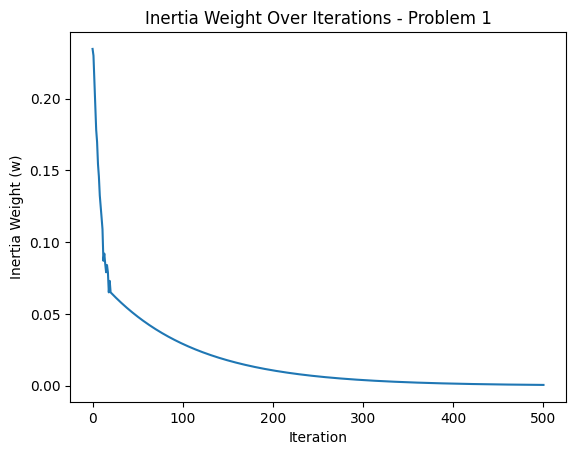

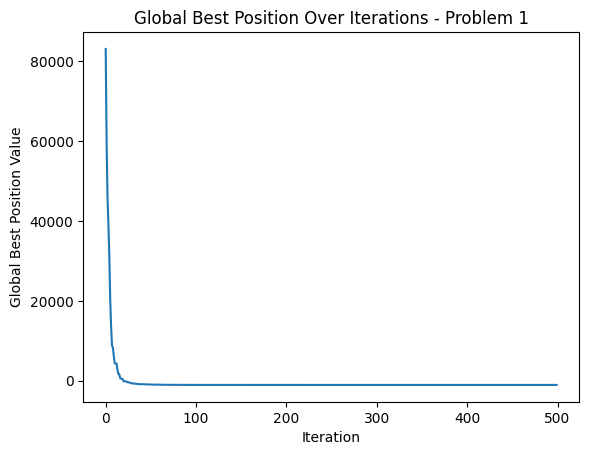




Problem 2 Best Cost: [-701.38729747 -701.40837043 -701.4230248  -701.46364106 -701.48281524
 -701.51552621 -701.56105016 -701.56105016 -701.56105016 -701.58354259
 -701.61343222 -701.63597504 -701.63597504 -701.66253356 -701.66483212
 -701.66483212 -701.67031521 -701.6886738  -701.68968513 -701.69344062
 -701.6969533  -701.69740173 -701.70331136 -701.70331136 -701.7247073
 -701.7247073  -701.73112102 -701.74415946 -701.75439562 -701.75439562
 -701.75439562 -701.76467567 -701.76871427 -701.76871427 -701.7808218
 -701.80483721 -701.80483721 -701.80483721 -701.80492131 -701.83098991
 -701.8475293  -701.8475293  -701.85158934 -701.85158934 -701.85158934
 -701.85194557 -701.85194557 -701.86005017 -701.86005017 -701.86911882
 -701.86911882 -701.86911882 -701.86911882 -701.86911882 -701.86911882
 -701.87081463 -701.87122924 -701.87587004 -701.88796231 -701.90186358
 -701.90186358 -701.90186358 -701.90186358 -701.91010353 -701.92733906
 -701.93312546 -701.93312546 -701.94161559 -701.9416155

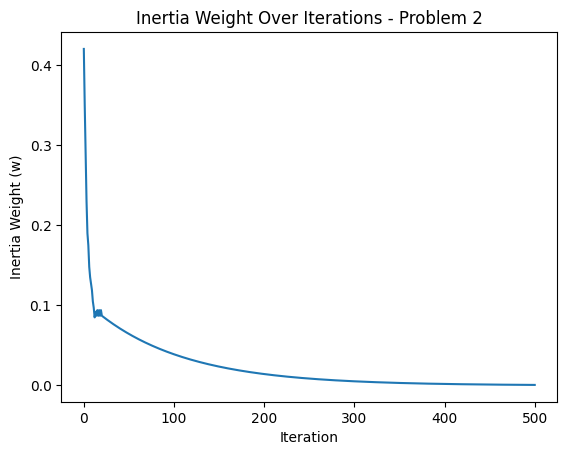

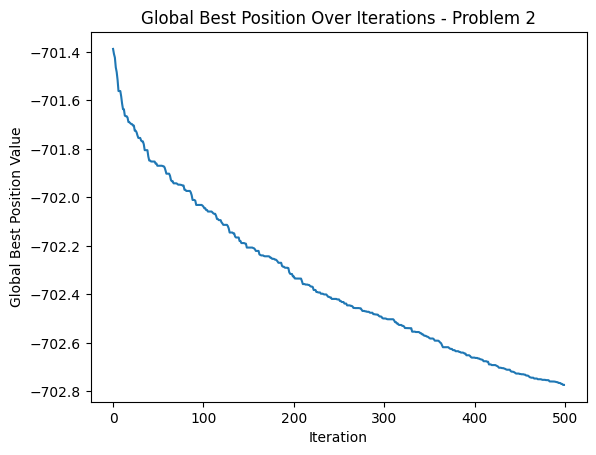




Problem 3 Best Cost: [ 3.41484527e+10  2.29038533e+10  1.93474567e+10  1.91402824e+10
  1.23078371e+10  1.00199410e+10  6.19281236e+09  5.87713528e+09
  5.07959896e+09  3.71329768e+09  3.28760799e+09  2.45451579e+09
  2.36453224e+09  2.00842198e+09  1.65120001e+09  1.14139056e+09
  9.37889808e+08  9.37889808e+08  9.37889808e+08  8.76011619e+08
  6.71150625e+08  6.71150625e+08  5.56259476e+08  5.14533808e+08
  4.29226861e+08  4.29226861e+08  4.27386737e+08  4.27386737e+08
  4.27386737e+08  3.77412038e+08  3.58227349e+08  2.50687144e+08
  2.50687144e+08  2.48980237e+08  2.11380942e+08  1.55813109e+08
  1.33688913e+08  1.33688913e+08  1.07170399e+08  9.29965410e+07
  9.29965410e+07  7.22441335e+07  7.22441335e+07  6.60990842e+07
  5.85002339e+07  5.68173500e+07  5.68173500e+07  5.59630133e+07
  5.36305008e+07  4.50958379e+07  3.74558709e+07  3.74558709e+07
  3.74558709e+07  3.74558709e+07  2.67746208e+07  2.67746208e+07
  2.67746208e+07  2.67746208e+07  2.45376823e+07  1.64113259e+07
 

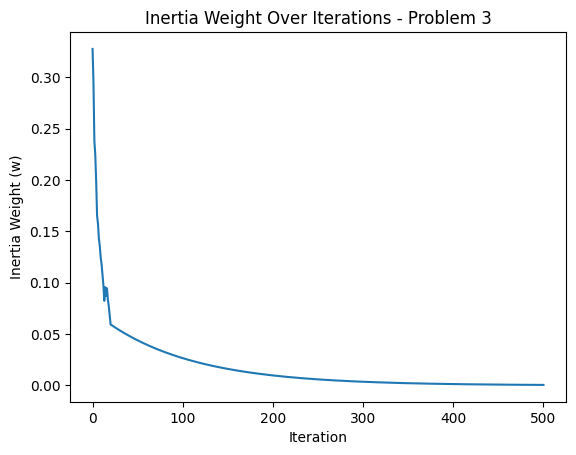

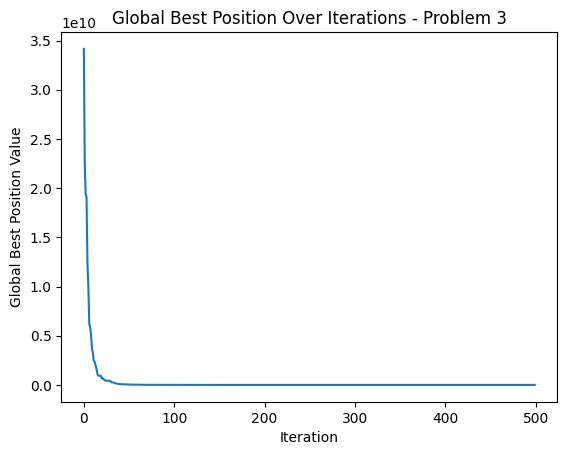




Problem 4 Best Cost: [ 3.01096765e+05  2.20071436e+05  1.72054740e+05  1.35853548e+05
  9.56475985e+04  7.17150339e+04  5.58404263e+04  3.36505434e+04
  2.79998881e+04  2.28041646e+04  2.06687669e+04  1.59347493e+04
  1.33096783e+04  9.05000016e+03  8.60611312e+03  8.60611312e+03
  7.94766544e+03  7.44701608e+03  6.61328863e+03  5.80410515e+03
  5.25122119e+03  4.79609378e+03  4.75914350e+03  4.75914350e+03
  4.26876784e+03  4.26876784e+03  4.11438169e+03  3.35404975e+03
  3.09431848e+03  2.12534483e+03  2.12534483e+03  2.12534483e+03
  2.12534483e+03  2.12534483e+03  1.62922454e+03  1.30384623e+03
  1.21259318e+03  1.02970404e+03  1.02970404e+03  7.87282202e+02
  7.87282202e+02  7.87282202e+02  7.76187170e+02  6.66386449e+02
  5.38348810e+02  5.38348810e+02  5.38348810e+02  4.28075602e+02
  4.09054596e+02  3.12236956e+02  2.42019885e+02  2.42019885e+02
  1.71019266e+02  8.26478897e+01  8.26478897e+01  4.97416217e+01
  4.97416217e+01  4.97416217e+01  4.91072008e+01  4.91072008e+01
 

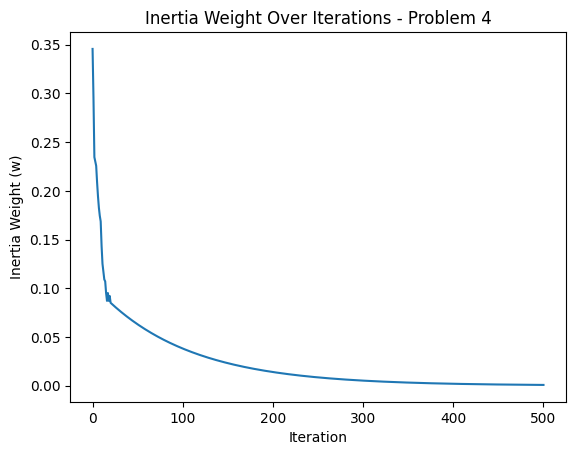

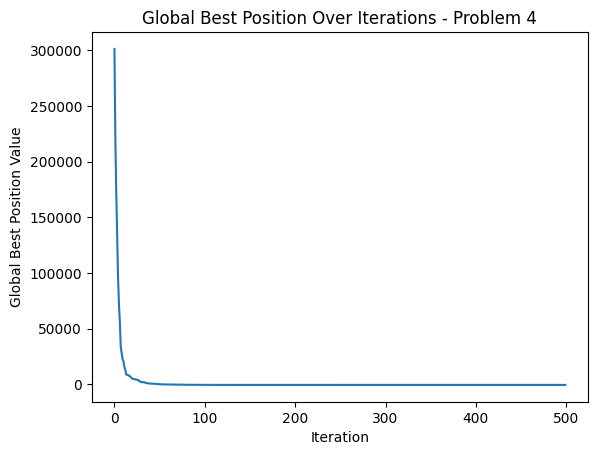




Problem 5 Best Cost: [-334.2363841  -334.2363841  -334.28845925 -334.31588956 -334.40425338
 -334.47820941 -334.50834582 -334.50834582 -334.52064581 -334.55879741
 -334.56290696 -334.57874257 -334.63410657 -334.63458822 -334.68789903
 -334.7064223  -334.71609681 -334.74127965 -334.74854321 -334.77974406
 -334.77974406 -334.79609219 -334.84498473 -334.84498473 -334.84498473
 -334.84614125 -334.86964534 -334.86964534 -334.91405611 -334.91405611
 -334.91405611 -334.9197166  -334.99053866 -334.99053866 -334.99053866
 -335.00218405 -335.01124625 -335.01124625 -335.01568661 -335.02192738
 -335.02779478 -335.03507995 -335.05071395 -335.0768816  -335.0768816
 -335.08369699 -335.09340607 -335.09340607 -335.09395071 -335.10473489
 -335.10473489 -335.10473489 -335.10473489 -335.11789843 -335.14442441
 -335.14442441 -335.14591917 -335.14608942 -335.16253859 -335.16253859
 -335.19707538 -335.20558289 -335.23012536 -335.23481071 -335.23481071
 -335.23481071 -335.23481071 -335.2441024  -335.244102

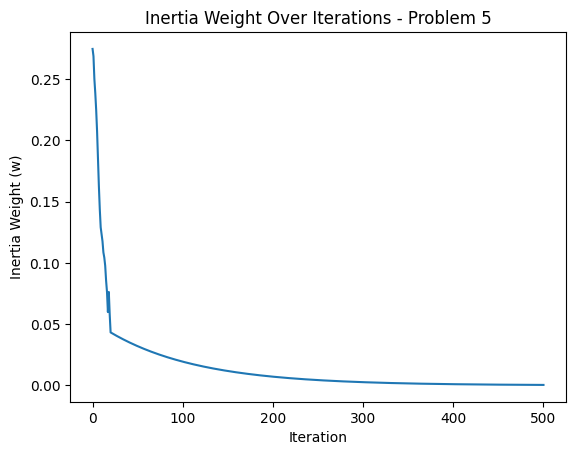

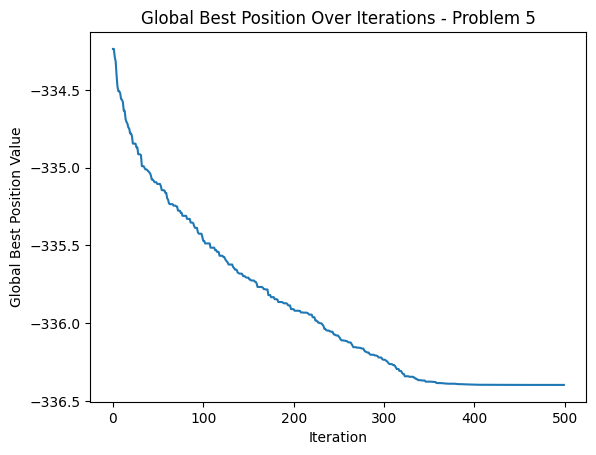




Problem 6 Best Cost: [-183.51155988 -183.58895626 -183.62985461 -183.66881696 -183.74346542
 -183.78440033 -183.82792123 -183.86262019 -183.89107596 -183.95094301
 -183.97702965 -183.98185421 -184.00958303 -184.04854727 -184.05742669
 -184.05742669 -184.05742669 -184.10263502 -184.1030778  -184.1521669
 -184.201979   -184.22242533 -184.22242533 -184.22911022 -184.22911022
 -184.23296296 -184.24037824 -184.24486977 -184.24486977 -184.28026175
 -184.28026175 -184.28026175 -184.28233072 -184.28602755 -184.3058721
 -184.3058721  -184.31614047 -184.31614047 -184.31817768 -184.3191269
 -184.34051462 -184.34051462 -184.36237933 -184.36469445 -184.36627069
 -184.36937945 -184.36937945 -184.38856788 -184.38856788 -184.38856788
 -184.40524912 -184.41394026 -184.41394026 -184.41394026 -184.4195266
 -184.43418366 -184.46829435 -184.47734736 -184.47734736 -184.47734736
 -184.47734736 -184.47734736 -184.48647501 -184.50495153 -184.50495153
 -184.50982902 -184.51894743 -184.51894743 -184.51894743 

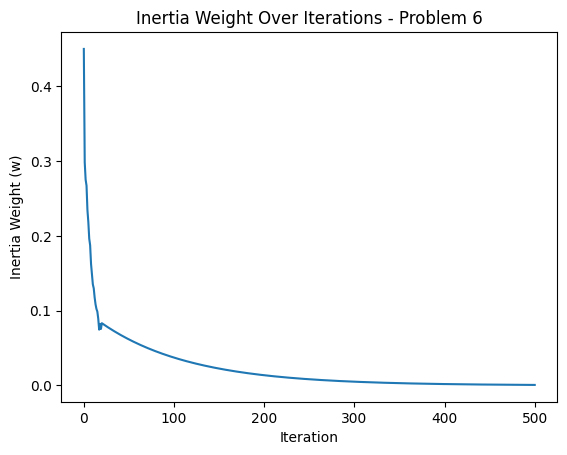

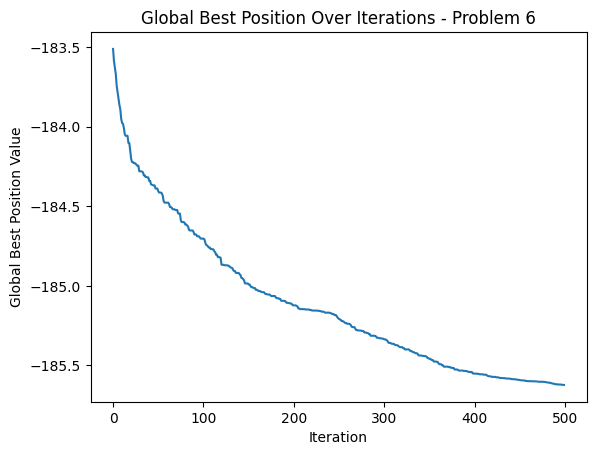




Problem 7 Best Cost: [79889.66812756 62329.25775021 51491.48649572 48167.43891291
 44719.45139345 35502.80476995 26152.4053568  23098.10750143
 15802.51244634 15223.51871901 15223.51871901 15223.51871901
 14953.54042759 13620.24304484 13620.24304484 13620.24304484
 12650.70198214 10850.39263116 10850.39263116 10850.39263116
 10850.39263116  9921.18294491  9921.18294491  9921.18294491
  8951.78164822  8951.78164822  8951.78164822  8951.78164822
  8650.66960082  8650.66960082  8464.74309783  8208.21452327
  8208.21452327  8176.0962545   8176.0962545   8176.0962545
  8176.0962545   8176.0962545   7408.54169129  6928.93444069
  6754.32863012  6754.32863012  6254.90837208  6104.75603118
  6076.24725325  5490.69294712  5490.69294712  5406.76246964
  4935.4299557   4935.4299557   4854.97767919  4847.08437855
  4527.23779025  4527.23779025  4527.23779025  4477.41521047
  4475.7743528   4459.10402295  4372.6292507   4372.6292507
  4285.51421332  4251.84982384  4210.57440456  4210.57440456
  

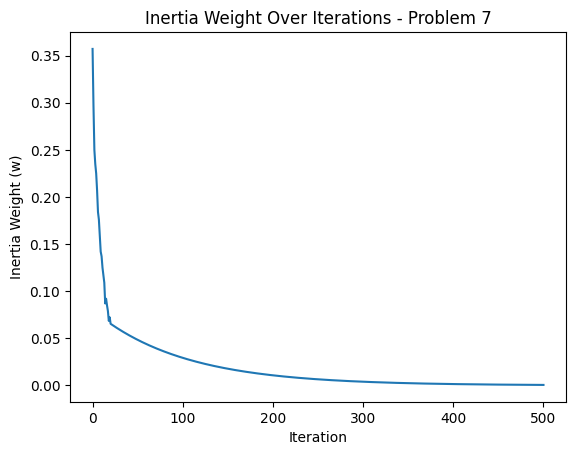

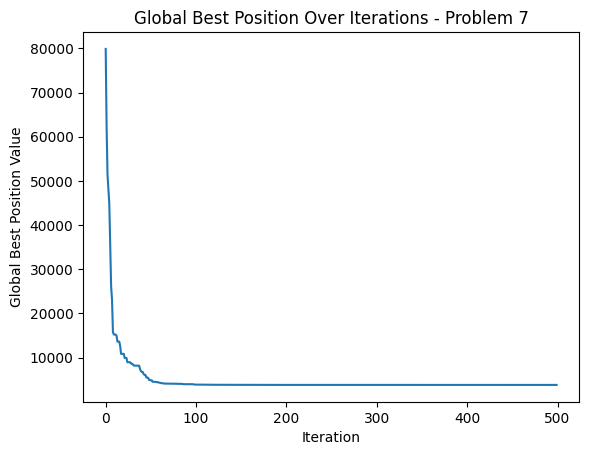




Problem 8 Best Cost: [81891.0328909  43591.21475698 43591.21475698 26502.97642729
 25101.51150655 25101.51150655 25101.51150655 25101.51150655
 25101.51150655 25101.51150655 25101.51150655 25101.51150655
 25101.51150655 25101.51150655 25101.51150655 25101.51150655
 25101.51150655 25101.51150655 25101.51150655 25101.51150655
 25101.51150655 25101.51150655 25101.51150655 25101.51150655
 22179.22923513 22179.22923513 22179.22923513 22179.22923513
 22179.22923513 21963.69610157 21963.69610157 19471.90678727
 19471.90678727 19471.90678727 19471.90678727 19471.90678727
 19471.90678727 19471.90678727 19471.90678727 19471.90678727
 19471.90678727 19471.90678727 19471.90678727 16760.51482233
 14734.10349928 14734.10349928 14584.69160819 14584.69160819
 14223.73593393 14223.73593393 14152.7473307  12830.72520079
 11971.60802737 11451.78262351 11451.78262351 10324.9271182
 10324.9271182  10324.9271182  10324.9271182  10324.9271182
  9777.06315436  9777.06315436  9777.06315436  9260.84995602
  

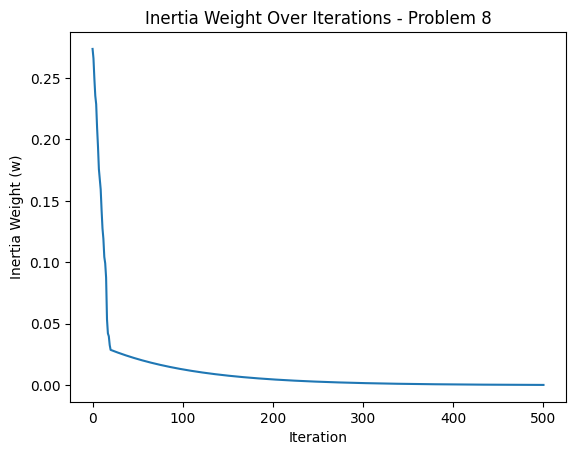

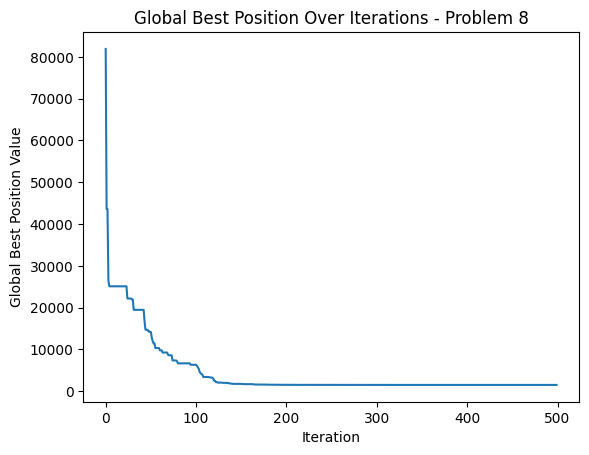




Problem 9 Best Cost: [164665.65012638 164665.65012638 100141.60453495 100141.60453495
 100141.60453495 100141.60453495 100141.60453495 100141.60453495
  70358.23412123  70358.23412123  70358.23412123  70358.23412123
  70358.23412123  56626.24297305  56626.24297305  47341.50568065
  47341.50568065  47341.50568065  47341.50568065  47341.50568065
  47341.50568065  47341.50568065  47341.50568065  47341.50568065
  47341.50568065  47341.50568065  47341.50568065  47341.50568065
  47341.50568065  41410.94574586  27309.23327124  27309.23327124
  27309.23327124  21436.28499307  21436.28499307  21436.28499307
  14607.76759753  14607.76759753  14607.76759753  14607.76759753
  14607.76759753  14607.76759753  14607.76759753  14607.76759753
  14607.76759753   9106.61788033   5726.10895707   5726.10895707
   5726.10895707   5726.10895707   5726.10895707   5726.10895707
   5726.10895707   5726.10895707   5268.04526979   4626.88135431
   4626.88135431   4626.88135431   4626.88135431   4626.88135431
 

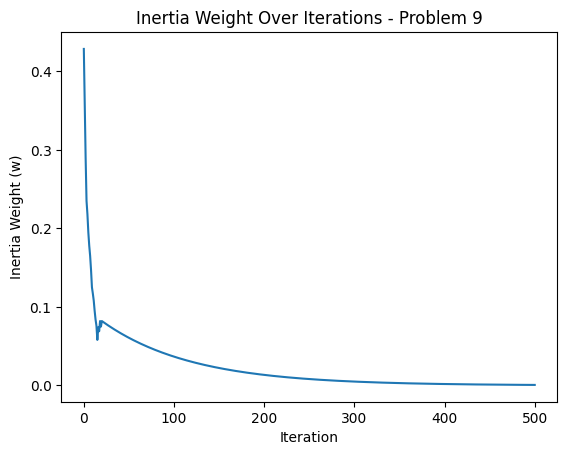

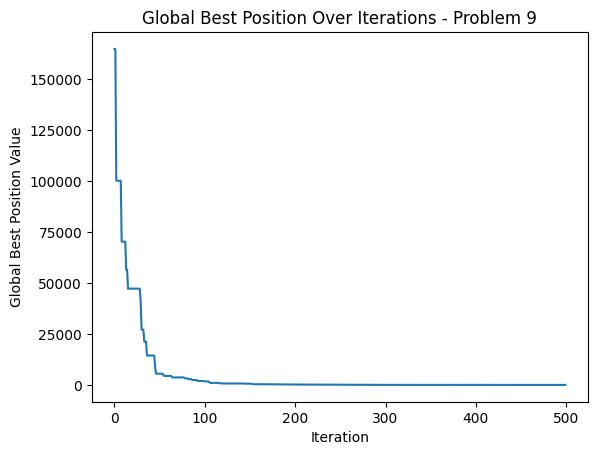




Problem 10 Best Cost: [56912.30608654 37110.95290333 37110.95290333 21816.57729923
 21816.57729923 21816.57729923 19964.3622898  17801.15538648
 17801.15538648 17801.15538648 15934.85051282 14271.54433383
 13316.70311778 11920.14536942  9377.54201587  8622.27364593
  8622.27364593  8622.27364593  8046.8092915   8031.5058412
  7724.79395293  7724.79395293  7158.9872035   7073.71874804
  7073.71874804  7073.71874804  6367.35628166  6367.35628166
  6367.35628166  6367.35628166  6367.35628166  4970.04327607
  4970.04327607  4970.04327607  4970.04327607  4970.04327607
  4970.04327607  4970.04327607  4970.04327607  4970.04327607
  4970.04327607  4970.04327607  4827.73431259  4827.73431259
  4827.73431259  4639.79690971  4636.54035717  4494.14043489
  4338.85173669  4338.85173669  4338.85173669  4331.13276155
  4275.57980961  4103.83733868  4103.83733868  4103.83733868
  4053.06974497  4053.06974497  4050.28669282  4050.28669282
  3915.80384699  3915.80384699  3866.37898701  3799.09794494


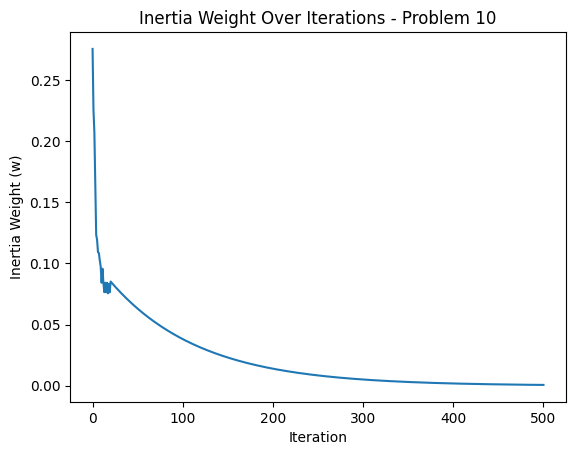

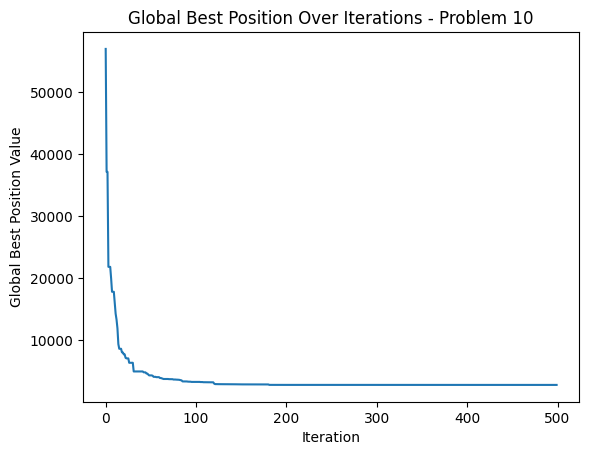




Problem 11 Best Cost: [78781.47237722 72704.64197527 55195.09881959 49378.28400804
 37649.55855025 33836.74629003 33836.74629003 33836.74629003
 33836.74629003 33836.74629003 33836.74629003 28538.47678759
 27214.40646801 23365.61609612 23365.61609612 23365.61609612
 19693.73018545 19693.73018545 18503.91321206 18503.91321206
 17156.50190266 13962.06099893 13962.06099893 13186.46926677
 10030.40346813  9545.72650398  9545.72650398  9545.72650398
  9545.72650398  9545.72650398  9545.72650398  9545.72650398
  9545.72650398  9545.72650398  9545.72650398  9545.72650398
  9545.72650398  9545.72650398  9545.72650398  9545.72650398
  9545.72650398  9545.72650398  9545.72650398  9444.45294857
  9444.45294857  9387.09914099  9387.09914099  9162.42958939
  9162.42958939  8985.24865858  8985.24865858  8935.97365571
  8806.87208943  8693.59047488  8063.08939005  8063.08939005
  8063.08939005  8063.08939005  8063.08939005  8063.08939005
  8063.08939005  8063.08939005  8063.08939005  8063.08939005

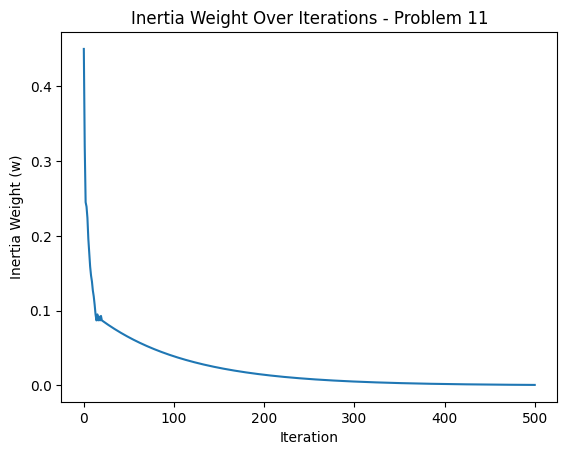

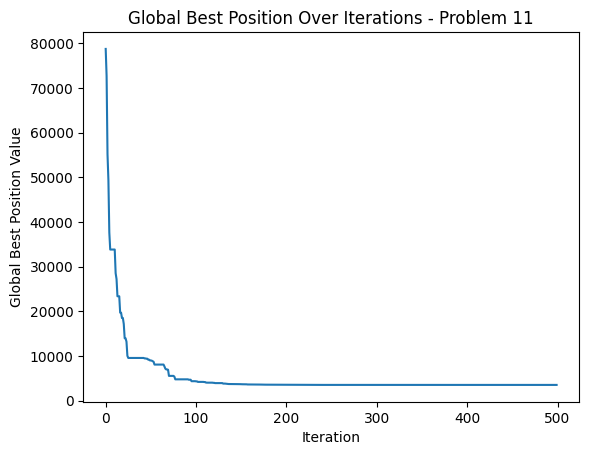




Problem 12 Best Cost: [49148.80131626 38195.6801497  38195.6801497  37170.42170141
 33470.66927927 19269.55904478 19269.55904478 19269.55904478
 17235.73062086 15584.50761544 15584.50761544 15584.50761544
 15584.50761544 15541.04681145 15541.04681145 15541.04681145
 15541.04681145 15541.04681145 15541.04681145 15358.15064856
 13727.29753929 12478.55684755 12478.55684755 12478.55684755
 12478.55684755 12226.83256641 12226.83256641 12226.83256641
 12226.83256641 11985.13954705 10740.43488824 10740.43488824
 10740.43488824 10588.97949144 10588.97949144  9994.59379117
  9994.59379117  8359.76054659  8359.76054659  8359.76054659
  8359.76054659  8359.76054659  8359.76054659  8359.76054659
  7809.97240186  7809.97240186  7809.97240186  7809.97240186
  7809.97240186  7809.97240186  7809.97240186  7809.97240186
  7809.97240186  7657.8078716   7657.8078716   7441.6203582
  7441.6203582   6090.75031543  6090.75031543  6090.75031543
  6090.75031543  6090.75031543  6090.75031543  6090.75031543


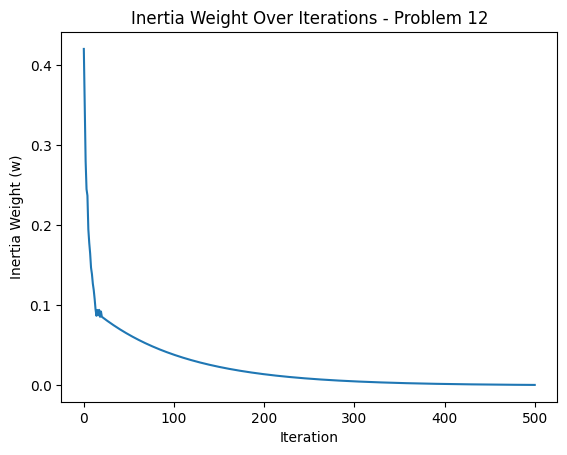

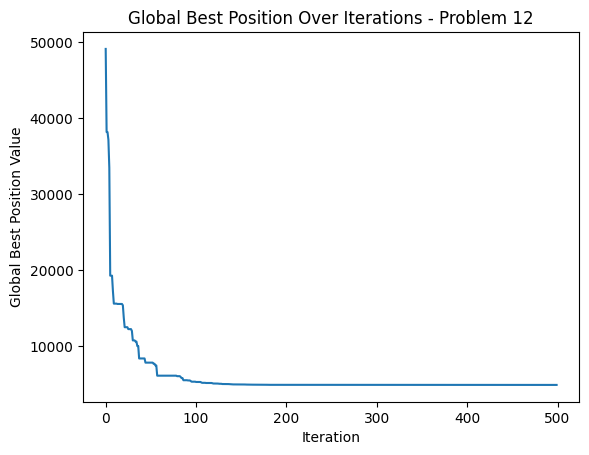




Problem 13 Best Cost: [154519.34689641 154519.34689641 154519.34689641 154519.34689641
 154519.34689641 154519.34689641 154519.34689641 154519.34689641
 154519.34689641 154519.34689641 154519.34689641 154519.34689641
 154519.34689641 154519.34689641 154519.34689641 154519.34689641
 154519.34689641 154519.34689641 154519.34689641 154519.34689641
 154519.34689641 154519.34689641 154519.34689641 154519.34689641
 154519.34689641 154519.34689641 124095.10784488 124095.10784488
 124095.10784488 124095.10784488 124095.10784488 124095.10784488
 124095.10784488 124095.10784488 124095.10784488 124095.10784488
 124095.10784488 124095.10784488 124095.10784488 124095.10784488
 124095.10784488 124095.10784488 124095.10784488 124095.10784488
 117100.15402086 117100.15402086 117100.15402086 117100.15402086
 117100.15402086 117100.15402086 117100.15402086 117100.15402086
 117100.15402086 117100.15402086 117100.15402086 117100.15402086
  93577.97324353  93577.97324353  93577.97324353  93577.97324353


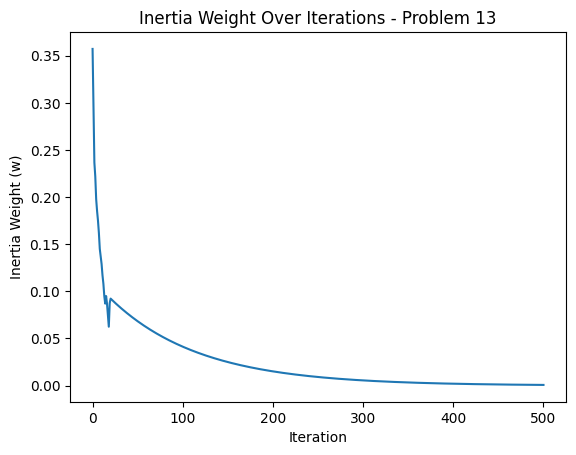

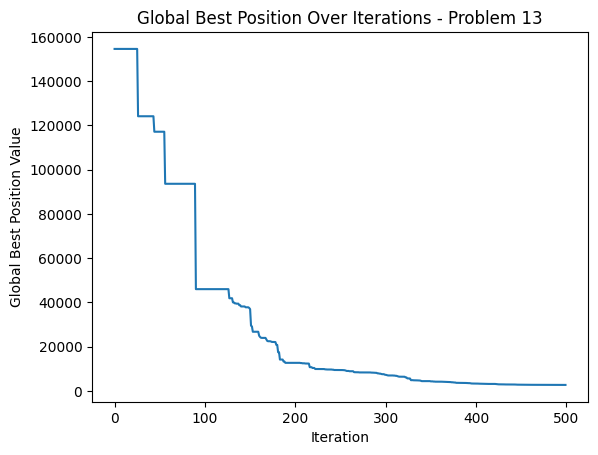




Problem 14 Best Cost: [34190.44342099 26606.47386593 24754.75468166 23324.43176771
 21564.1899554  20264.9987542  18601.37006413 16510.86997309
 15833.55540887 15833.55540887 14220.7624626  14220.7624626
 14220.7624626  13445.48271547 13445.48271547 13445.48271547
 13445.48271547 13445.48271547 13445.48271547 13445.48271547
 13445.48271547 13445.48271547 13445.48271547 13445.48271547
 13445.48271547 13445.48271547 12103.23147103 12103.23147103
 12103.23147103 12103.23147103 12103.23147103 12103.23147103
 12103.23147103 12103.23147103 12103.23147103 11945.8089905
 11945.8089905  11945.8089905  11945.8089905  11563.30759069
 10944.38057186 10828.49961118 10828.49961118 10828.49961118
 10828.49961118 10828.49961118 10828.49961118 10828.49961118
 10828.49961118 10828.49961118 10828.49961118 10828.49961118
 10828.49961118 10828.49961118  9229.7049391   9229.7049391
  9229.7049391   9229.7049391   9229.7049391   9229.7049391
  9229.7049391   9229.7049391   9229.7049391   9229.7049391
  92

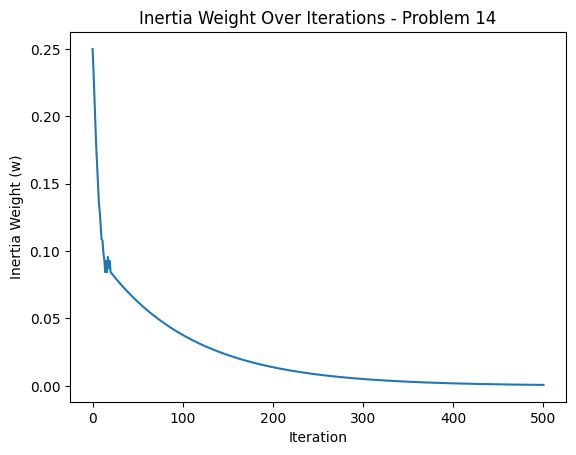

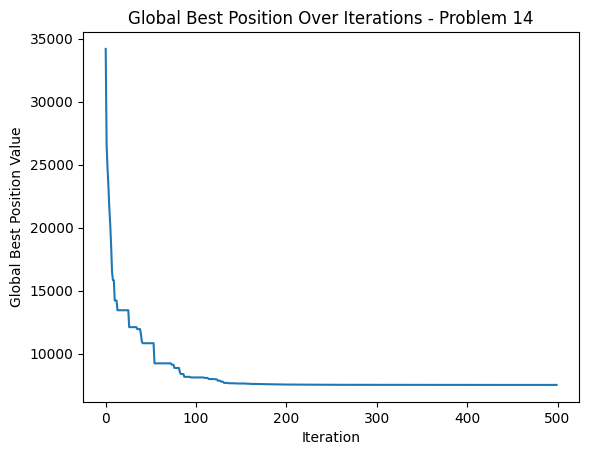




Problem 15 Best Cost: [-224.82257839 -224.82257839 -224.82257839 -225.55822593 -225.55822593
 -225.55822593 -225.55822593 -225.55822593 -225.90120056 -225.90120056
 -226.4982681  -226.4982681  -226.4982681  -226.62062707 -226.62062707
 -226.62062707 -226.62062707 -226.7174801  -226.80240938 -226.80240938
 -226.80240938 -226.80240938 -226.80240938 -226.80240938 -226.80240938
 -226.80240938 -226.80240938 -226.80240938 -226.80240938 -226.89790334
 -226.9164208  -226.9164208  -226.9164208  -227.0814514  -227.0814514
 -227.14739146 -227.14739146 -227.1507046  -227.1507046  -227.23371263
 -227.26651249 -227.26651249 -227.31044488 -227.31044488 -227.31044488
 -227.31044488 -227.31044488 -227.31044488 -227.32034012 -227.32034012
 -227.39914998 -227.39914998 -227.39914998 -227.39914998 -227.39914998
 -227.39914998 -227.39914998 -227.39914998 -227.52297933 -227.52297933
 -227.52297933 -227.52297933 -227.60226702 -227.60226702 -227.60226702
 -227.6370468  -227.6370468  -227.68826225 -227.68826

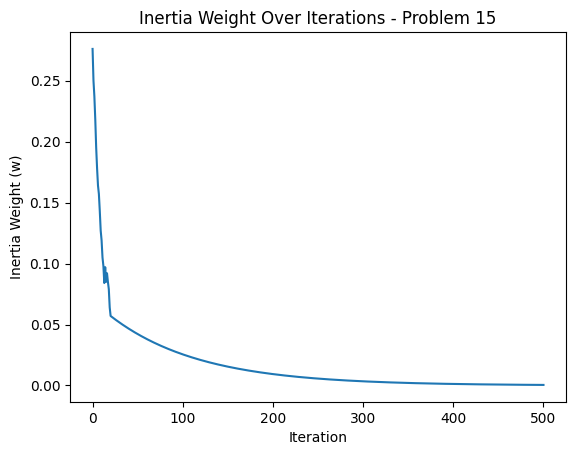

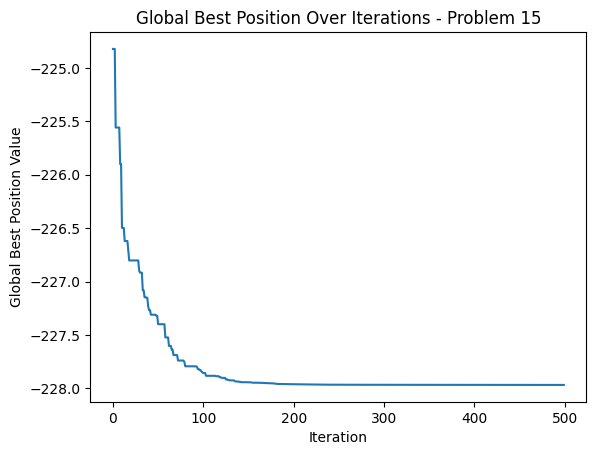




Problem 16 Best Cost: [ 5.80475974e+04  4.07333643e+04  2.77456075e+04  1.95016916e+04
  1.47361800e+04  7.38698000e+03  1.20286369e+03  1.13096374e+03
  1.13096374e+03  3.64574328e+02  3.38935910e+01 -1.66283803e+03
 -2.15250129e+03 -2.38034096e+03 -2.38034096e+03 -2.38034096e+03
 -3.06692535e+03 -3.30731833e+03 -3.33374030e+03 -3.33374030e+03
 -3.46885469e+03 -3.64685926e+03 -3.67207955e+03 -3.78388140e+03
 -3.83662789e+03 -3.97364777e+03 -4.04770265e+03 -4.04770265e+03
 -4.04770265e+03 -4.04770265e+03 -4.04770265e+03 -4.05277401e+03
 -4.06300561e+03 -4.12665534e+03 -4.12665534e+03 -4.12665534e+03
 -4.14824792e+03 -4.14824792e+03 -4.14824792e+03 -4.14824792e+03
 -4.15569569e+03 -4.15569569e+03 -4.17830951e+03 -4.17830951e+03
 -4.23663128e+03 -4.23663128e+03 -4.23663128e+03 -4.23663128e+03
 -4.23663128e+03 -4.25296469e+03 -4.25296469e+03 -4.25296469e+03
 -4.25296469e+03 -4.25296469e+03 -4.25905663e+03 -4.27144616e+03
 -4.27153151e+03 -4.27464411e+03 -4.27809554e+03 -4.28220059e+03


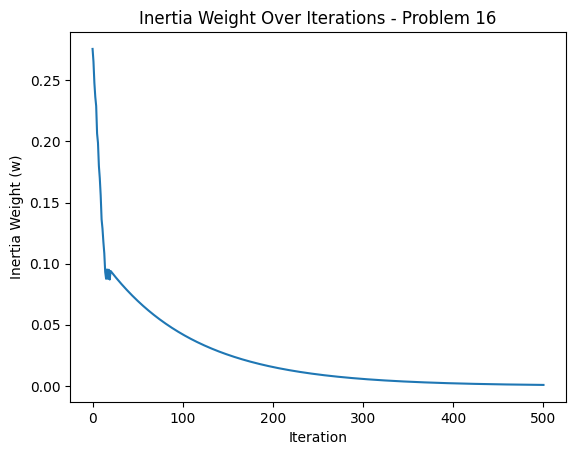

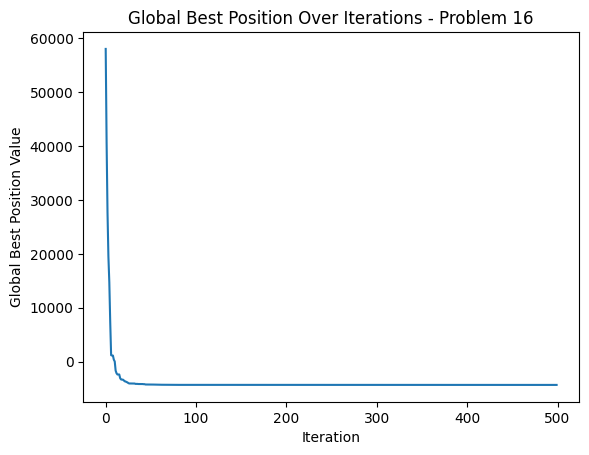




Problem 17 Best Cost: [ 3.04142060e+06  2.49462960e+06  1.64240082e+06  1.34241195e+06
  9.50231683e+05  6.61997571e+05  4.59241028e+05  3.77360003e+05
  3.77360003e+05  3.27563897e+05  3.27563897e+05  2.43511655e+05
  2.02631287e+05  1.44742419e+05  1.44742419e+05  1.44742419e+05
  1.24222318e+05  1.03172596e+05  1.03172596e+05  9.78167404e+04
  9.78167404e+04  7.17887109e+04  5.37263732e+04  4.44840641e+04
  4.02340778e+04  3.66736151e+04  3.66736151e+04  3.54096574e+04
  3.01373564e+04  1.70592908e+04  1.70592908e+04  1.70592908e+04
  1.70592908e+04  1.70592908e+04  1.69807476e+04  1.31584602e+04
  1.31584602e+04  1.31584602e+04  1.21506761e+04  1.21506761e+04
  1.05809604e+04  1.05809604e+04  9.55839283e+03  7.53869818e+03
  7.48744758e+03  7.48744758e+03  5.79045184e+03  5.79045184e+03
  5.46702139e+03  5.46702139e+03  3.86508868e+03  3.48906723e+03
  3.24021959e+03  2.60280045e+03  2.27403449e+03  2.16670348e+03
  1.83414469e+03  1.57981147e+03  1.17061382e+03  8.31171707e+02


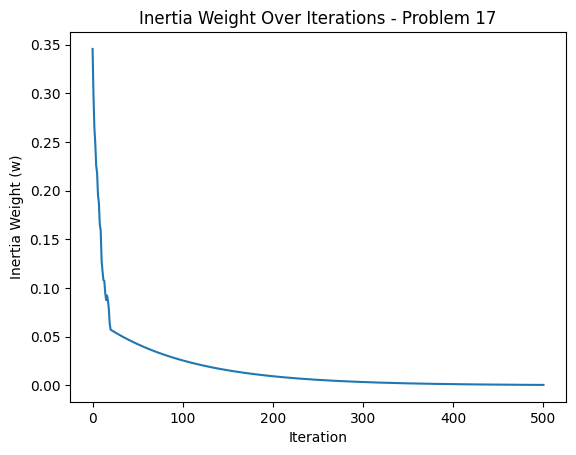

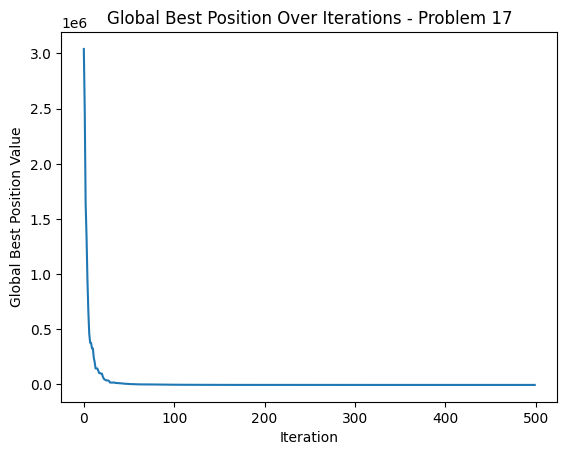




Problem 18 Best Cost: [52845.42634369 52845.42634369 37825.68759982 37825.68759982
 37825.68759982 37825.68759982 37825.68759982 34061.1802411
 34061.1802411  34061.1802411  28561.63394532 28561.63394532
 26002.07195879 26002.07195879 26002.07195879 23876.72599319
 23876.72599319 23876.72599319 23876.72599319 23876.72599319
 23876.72599319 23245.62093064 23245.62093064 23245.62093064
 23245.62093064 23245.62093064 23245.62093064 21472.46639997
 18444.2689126  18444.2689126  18444.2689126  18444.2689126
 17799.54292598 17799.54292598 17058.60693817 17058.60693817
 17058.60693817 13954.33992588 10596.40570037  9374.65445268
  7107.5978397   7107.5978397   7107.5978397   7107.5978397
  7107.5978397   7107.5978397   6153.8773994   6153.8773994
  6153.8773994   5148.52827941  5148.52827941  5148.52827941
  5148.52827941  5148.52827941  5148.52827941  4819.2317308
  4819.2317308   4712.07992637  4322.77138839  4322.77138839
  4322.77138839  4250.45203144  4250.45203144  4250.45203144
  42

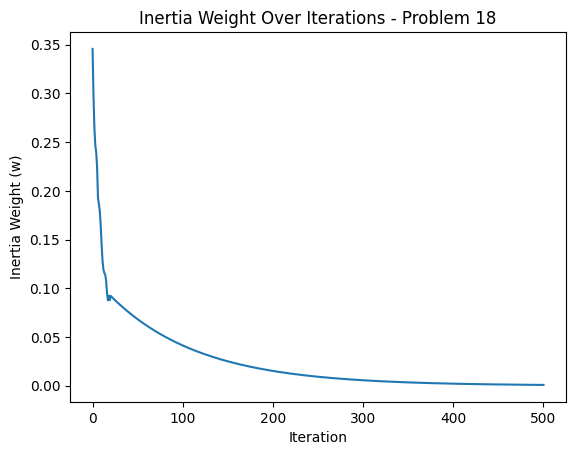

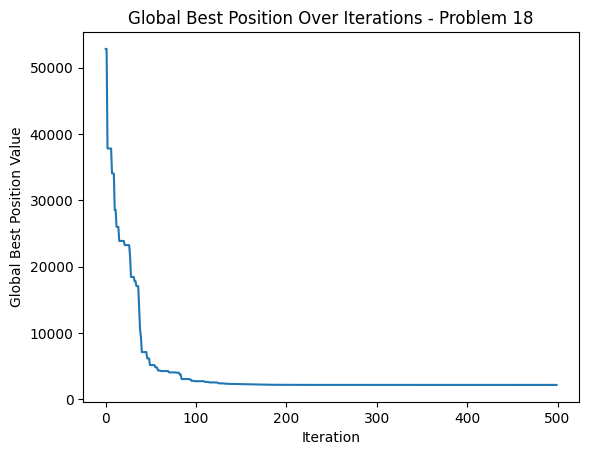




Problem 19 Best Cost: [45800.79795084 45800.79795084 45800.79795084 33233.05346118
 23631.88362896 23631.88362896 23631.88362896 23631.88362896
 23631.88362896 23631.88362896 23631.88362896 23631.88362896
 23631.88362896 23631.88362896 23631.88362896 23631.88362896
 23631.88362896 23631.88362896 23631.88362896 23631.88362896
 23631.88362896 23631.88362896 23631.88362896 23631.88362896
 23631.88362896 23631.88362896 22493.47726857 22493.47726857
 22493.47726857 22493.47726857 22493.47726857 22493.47726857
 22493.47726857 22493.47726857 22493.47726857 22493.47726857
 22493.47726857 22493.47726857 22493.47726857 22493.47726857
 18932.7331829  18932.7331829  18932.7331829  18932.7331829
 18932.7331829  18932.7331829  18932.7331829  18932.7331829
 18932.7331829  18932.7331829  18932.7331829  18932.7331829
 18932.7331829  18932.7331829  18932.7331829  18932.7331829
 18932.7331829  18310.22159941 18310.22159941 18310.22159941
 18310.22159941 18310.22159941 18310.22159941 18310.22159941
 18

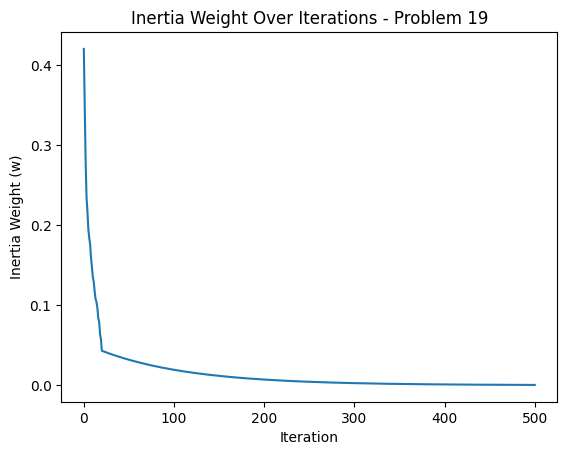

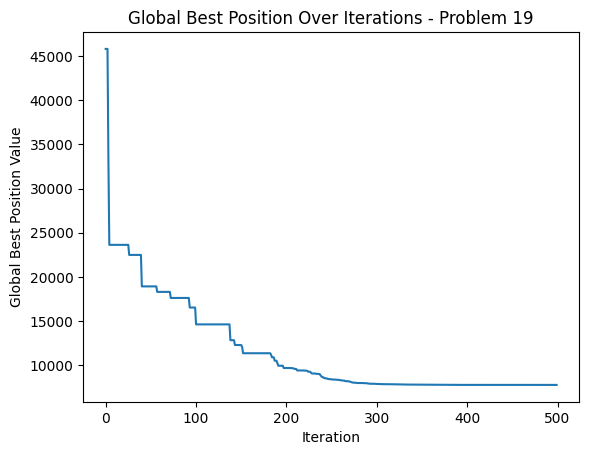




Problem 20 Best Cost: [-82.22120311 -83.38846433 -84.61667318 -85.18800803 -85.47515624
 -85.68580477 -85.68580477 -85.68580477 -86.21853615 -86.21853615
 -86.81610644 -86.81610644 -86.81610644 -86.81610644 -86.81610644
 -86.83003035 -86.9727469  -87.15751579 -87.15751579 -87.15751579
 -87.2366428  -87.2366428  -87.2366428  -87.2366428  -87.40872432
 -87.40872432 -87.40872432 -87.40872432 -87.4761974  -87.4761974
 -87.4761974  -87.82435001 -87.82435001 -87.82435001 -87.97308895
 -88.004803   -88.08454102 -88.08454102 -88.08454102 -88.08454102
 -88.08454102 -88.08454102 -88.26712736 -88.26712736 -88.26712736
 -88.26712736 -88.26712736 -88.26712736 -88.26712736 -88.26712736
 -88.37763813 -88.37763813 -88.37763813 -88.41930957 -88.41930957
 -88.41930957 -88.44179513 -88.44179513 -88.44498127 -88.47640716
 -88.47640716 -88.47640716 -88.5553584  -88.5553584  -88.5553584
 -88.69732501 -88.69732501 -88.69732501 -88.69732501 -88.69732501
 -88.69732501 -88.69732501 -88.74520772 -88.74520772 

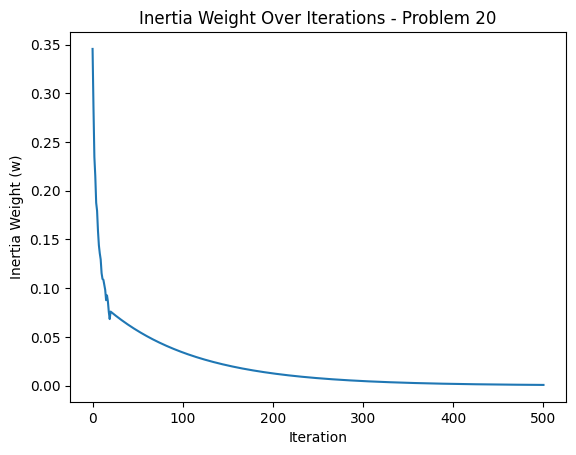

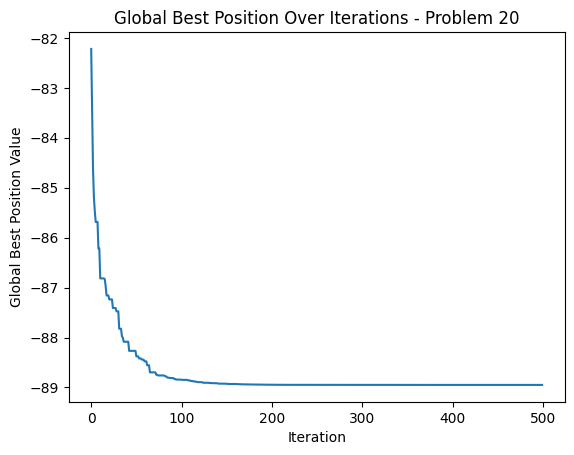




Problem 21 Best Cost: [150.84123555 102.37896598  57.91957188  23.92991506  22.8384819
  18.60204139  15.52531043   5.37692736   3.00799916  -4.64806347
  -4.64806347  -5.32571293  -8.79560282 -11.34972232 -12.42034673
 -13.44651085 -14.73753917 -17.14774354 -17.71707633 -18.2480277
 -18.2480277  -20.03746623 -20.03746623 -22.33647003 -22.33647003
 -22.70821935 -26.63154359 -26.63154359 -26.63154359 -26.95340865
 -26.95340865 -26.95340865 -26.95340865 -26.95340865 -27.02632214
 -27.02632214 -27.02632214 -27.02632214 -27.98694175 -30.06678702
 -30.06678702 -30.06678702 -31.3947109  -31.3947109  -31.3947109
 -32.16111568 -32.16111568 -32.89410252 -32.89410252 -33.2537536
 -33.98374683 -34.28035261 -35.1640789  -36.04025747 -36.81122713
 -36.81122713 -36.87852274 -36.87852274 -36.91807483 -36.91807483
 -36.91807483 -37.71991363 -37.71991363 -38.03373704 -38.03373704
 -38.03373704 -38.03373704 -38.19644849 -38.69617406 -39.03432787
 -39.03432787 -39.03432787 -39.03585387 -39.06557062 -3

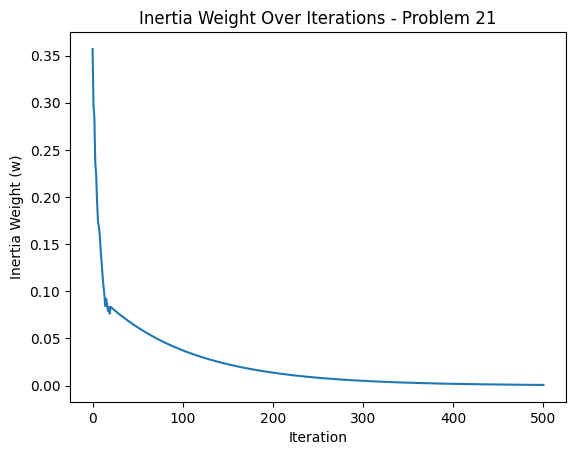

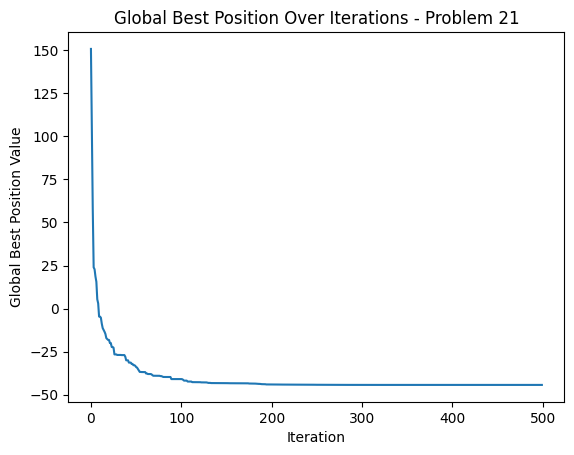




Problem 22 Best Cost: [263872.02622936 251705.01242611 243623.53021969 218664.51991699
 213367.49271431 199443.98836763 199443.98836763 199443.98836763
 193281.91789022 185693.132402   185693.132402   185693.132402
 185693.132402   176266.14117897 176266.14117897 176266.14117897
 176266.14117897 157412.2405868  156128.33537276 156128.33537276
 156128.33537276 156128.33537276 156128.33537276 156128.33537276
 156128.33537276 147879.93491553 147879.93491553 147879.93491553
 147879.93491553 147879.93491553 144725.73560315 144725.73560315
 144725.73560315 144725.73560315 144725.73560315 144725.73560315
 144725.73560315 144725.73560315 144725.73560315 144725.73560315
 144725.73560315 138683.82567442 138683.82567442 138683.82567442
 138683.82567442 138683.82567442 138683.82567442 134850.21587178
 133089.34191966 133089.34191966 126353.49151218 126353.49151218
 126353.49151218 126353.49151218 126353.49151218 126353.49151218
 120854.6976947  120854.6976947  116236.94505868 116236.94505868
 1

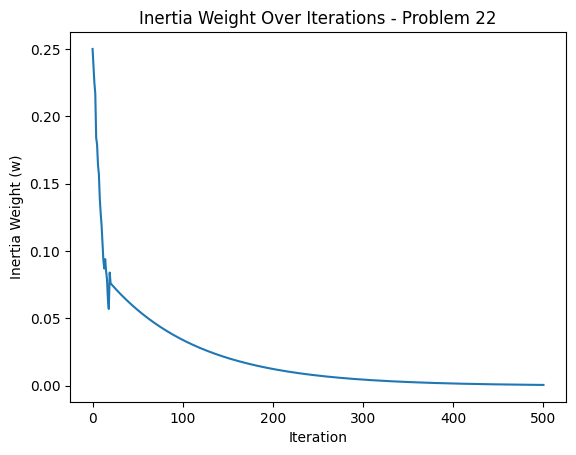

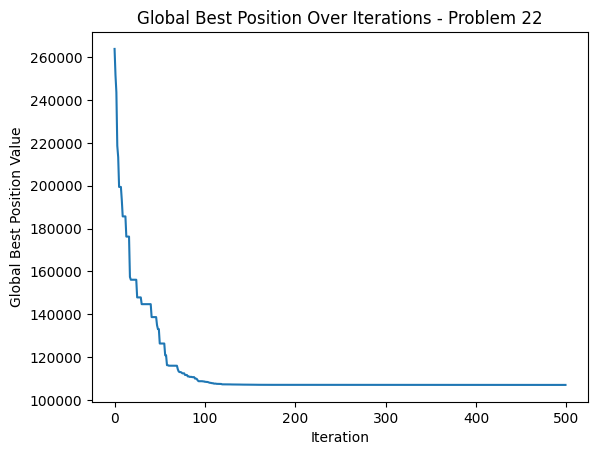




Problem 23 Best Cost: [-14.78353057 -27.69879098 -29.34107138 -29.86161317 -32.04322591
 -35.39294102 -41.13185062 -42.7730854  -44.85148196 -44.85148196
 -44.85148196 -44.85148196 -49.76241172 -49.76241172 -49.76241172
 -49.76241172 -49.76241172 -49.76241172 -50.66069698 -50.66069698
 -50.66069698 -50.66069698 -51.1672846  -51.1672846  -51.1672846
 -51.1672846  -51.1672846  -51.1672846  -54.28440052 -54.28440052
 -54.28440052 -54.28440052 -54.28440052 -54.28440052 -54.28440052
 -54.28440052 -54.28440052 -54.28440052 -54.28440052 -54.28440052
 -54.28440052 -54.28440052 -54.61768156 -54.61768156 -55.14526419
 -55.14526419 -55.14526419 -55.14526419 -55.14526419 -55.14526419
 -55.14526419 -55.14526419 -55.14526419 -55.14526419 -55.14526419
 -55.14526419 -55.18740069 -55.18740069 -55.18740069 -56.4776043
 -56.4776043  -56.4776043  -56.4776043  -56.4776043  -56.4776043
 -56.4776043  -56.4776043  -56.4776043  -56.4776043  -56.4776043
 -56.4776043  -56.4776043  -56.4776043  -56.4776043  -5

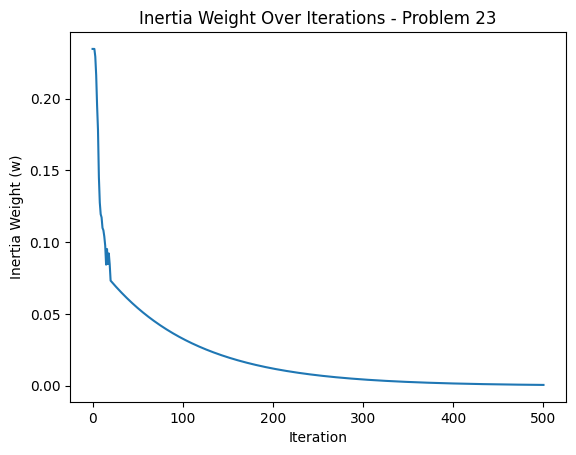

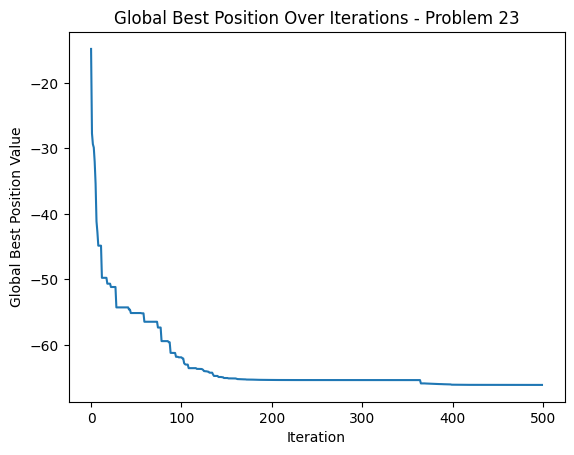




Problem 24 Best Cost: [114.0230167  107.88983182 100.54649044  92.77100324  76.26977213
  67.56666107  44.25693037  41.40990581  37.60162491  35.3601086
  31.89079444  21.77521602  20.61009003  14.13977078  10.25947891
  10.19465495  -5.11437781  -5.11437781  -5.11437781  -5.11437781
  -5.11437781  -5.11437781  -5.11437781  -5.11437781  -5.11437781
  -5.11437781  -5.3874095   -6.09997858  -6.09997858  -6.09997858
  -7.90505053  -9.47691253  -9.47691253  -9.47691253 -14.65822284
 -14.65822284 -15.72432979 -15.72432979 -22.23293528 -22.23293528
 -22.23293528 -22.23293528 -22.23293528 -22.23293528 -22.34713262
 -22.34713262 -22.34713262 -23.25261881 -23.25261881 -23.25261881
 -23.25261881 -23.25261881 -24.06171465 -24.06171465 -24.06171465
 -24.06171465 -24.06171465 -24.06171465 -24.06171465 -26.37544516
 -26.37544516 -26.37544516 -26.37544516 -27.86261786 -27.86261786
 -27.86261786 -27.86261786 -30.33849082 -30.33849082 -30.33849082
 -30.87003469 -30.87003469 -30.87003469 -30.87003469

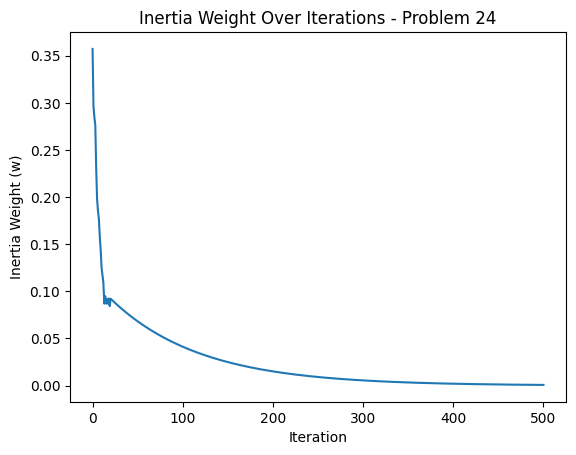

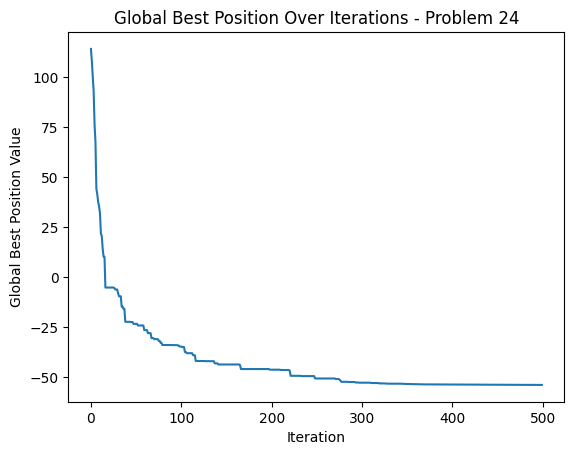

In [21]:
for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]

    print("\n\n\nProblem", curr, "Best Cost:", problem_results['BestCost'])
    print("Problem", curr, "Best Position:", problem_results['BestPosition'])

    plt.plot(problem_results['w_values'])
    plt.xlabel('Iteration')
    plt.ylabel('Inertia Weight (w)')
    plt.title(f'Inertia Weight Over Iterations - Problem {curr}')
    plt.show()

    plt.plot(problem_results['g_values'])
    plt.xlabel('Iteration')
    plt.ylabel('Global Best Position Value')
    plt.title(f'Global Best Position Over Iterations - Problem {curr}')
    plt.show()

In [22]:
print('nice')

nice


In [23]:
print('almost complete')

almost complete


In [24]:
print("Don't disconnect runtime")

Don't disconnect runtime


In [25]:
ok

NameError: name 'ok' is not defined